# Učitavanje modula

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import MaxNLocator
import numpy as np
from datetime import datetime
import calendar
import os

# Učitavanje podataka

In [2]:
DATA_CLEANED_PATH = '../data/interim/data_no_cancellations.parquet'
DATA_CANCELED_PATH = '../data/interim/data_cancellations.parquet'

DATA_HOTEL0_BASE_PATH = '../data/interim/hotel_0'
DATA_HOTEL1_BASE_PATH = '../data/interim/hotel_1'

DATA_HOTEL0_PATH = '../data/interim/hotel_0/hotel0cleaned.parquet'
DATA_HOTEL1_PATH = '../data/interim/hotel_1/hotel1cleaned.parquet'

In [3]:
data_cancellations = pd.read_parquet(DATA_CANCELED_PATH)
data_no_cancellations = pd.read_parquet(DATA_CLEANED_PATH)
data_cancellations.head()


hotel_id datum_dolaska datum_otkazivanja_rezervacije zemlja_gosta  \
0         0    2015-07-01                    2015-05-06          PRT   
1         0    2015-07-01                    2015-04-22          PRT   
2         0    2015-07-01                    2015-06-23          PRT   
3         0    2015-07-01                    2015-05-11          PRT   
4         0    2015-07-01                    2015-05-29          PRT   

   kanal_prodaje_id  tip_sobe_id  cijena_nocenja  gost_id  ukupno_gostiju  \
0                 2            1       61.437192  1075633               2   
1                 2            2      150.365262  1056139               2   
2                 2            3      142.635814  1020092               2   
3                 2            3      113.277032  1018277               2   
4                 0            3      105.416363  1035627               2   

   duljina_boravka  raspon_dolazak_rezervacija  
0                3                           1  
1                3                           3  
2                4                          75  
3                7                         178  
4               10                         181

Opis stupaca:
- hotel_id : int, dvije vrste hotela: hotel 0 i hotel 1
- datum_dolaska :  datum kada bi gost trebao stići u hotel
- datum_otkazivanja_rezervacije: samo za podatkovni okvir s podacima o otkazanim rezervacijama
- zemlja_gosta : zemlja iz koje gost dolazi. Kategorije su zapisane u ISO 3155–3:2013 formatu
- kanal_prodaje_id : id kanala prodaje preko kojeg je rezervacija napravljena (primjeri: direktna rezervacija, agencija, online)
- tip_sobe_id : id tipa sobe koju je gost rezervirao
- cijena_nocenja : cijena jednog noćenja za pojedinu rezeraciju
- gost_id : identifikacijski broj gosta
- ukupno_gostiju : int, broj ukupnog broja gostiju za danu rezervaciju
- duljina_boravka: dani boravka osoba u hotelu u danoj rezervaciji
- raspon_dolazak_rezervacija : razlika u brojima dana izmedu dana dolaska gosta i dana kreiranja rezervacije

In [4]:
hotel_resort_cancellations = data_cancellations[data_cancellations['hotel_id'] == 0]
hotel_city_cancellations = data_cancellations[data_cancellations['hotel_id'] == 1]

assert (len(hotel_resort_cancellations)+ len(hotel_city_cancellations)) == len(data_cancellations)

In [5]:
hotel_resort_no_cancellations = data_no_cancellations[data_no_cancellations['hotel_id'] == 0]
hotel_city_no_cancellations = data_no_cancellations[data_no_cancellations['hotel_id'] == 1]

assert (len(hotel_resort_no_cancellations)+ len(hotel_city_no_cancellations)) == len(data_no_cancellations)

In [6]:
percent_hotel_resort_cancellations = (len(hotel_resort_cancellations) / len(data_cancellations)) * 100
percent_hotel_city_cancellations = (len(hotel_city_cancellations) / len(data_cancellations)) * 100
percent_hotel_resort_no_cancellations = (len(hotel_resort_no_cancellations) / len(data_no_cancellations)) * 100
percent_hotel_city_no_cancellations = (len(hotel_city_no_cancellations) / len(data_no_cancellations)) * 100

print(f"Resort hotel ima {percent_hotel_resort_cancellations} % svih zapisa o otkazima u originalnom podatkovnom skupu")
print(f"City hotel ima {percent_hotel_city_cancellations} % svih zapisa o otkazima u originalnom podatkovnom skupu")

print(f"Resorthotel ima {percent_hotel_resort_no_cancellations} % svih zapisa bez otkaza u originalnom podatkovnom skupu")
print(f"City hotel ima {percent_hotel_city_no_cancellations} % svih zapisa bez otkaza u originalnom podatkovnom skupu")

Resort hotel ima 25.105485232067508 % svih zapisa o otkazima u originalnom podatkovnom skupu
City hotel ima 74.89451476793249 % svih zapisa o otkazima u originalnom podatkovnom skupu
Resorthotel ima 38.05994373512227 % svih zapisa bez otkaza u originalnom podatkovnom skupu
City hotel ima 61.94005626487773 % svih zapisa bez otkaza u originalnom podatkovnom skupu


# Promatranje cijene u hotelima

- Gledamo cijene na sljedeći način:
    - za svaku rezervaciju dobijemo cijenu po osobi
    - za svaki dan/tjedan/mjesec dobijemo prosječnu cijenu (uzimajući i ne uzimajući godinu u obzir)
    - napravimo isto za različite vrste soba i kanala prodaje
    - napravimo sve prethodno za ostvarene i neostvarene rezervacije obaju hotela

In [7]:
# DODANO ZBOG PODIGNUTOG UPOZORENJA OD PYTHONA
hotel_resort_cancellations = hotel_resort_cancellations.copy()
hotel_city_cancellations = hotel_city_cancellations.copy()
hotel_resort_no_cancellations = hotel_resort_no_cancellations.copy()
hotel_city_no_cancellations = hotel_city_no_cancellations.copy()

In [8]:
hotel_resort_cancellations['datum_dolaska'] = pd.to_datetime(hotel_resort_cancellations['datum_dolaska'])
hotel_city_cancellations['datum_dolaska'] = pd.to_datetime(hotel_city_cancellations['datum_dolaska'])
hotel_resort_no_cancellations['datum_dolaska'] = pd.to_datetime(hotel_resort_no_cancellations['datum_dolaska'])
hotel_city_no_cancellations['datum_dolaska'] = pd.to_datetime(hotel_city_no_cancellations['datum_dolaska'])

KORAK 1: Cijena po osobi po rezervaciji

In [9]:
hotel_resort_cancellations.loc[:, 'cijena_nocenja_po_osobi'] = hotel_resort_cancellations['cijena_nocenja'] / hotel_resort_cancellations['ukupno_gostiju']
hotel_city_cancellations.loc[:, 'cijena_nocenja_po_osobi'] = hotel_city_cancellations['cijena_nocenja'] / hotel_city_cancellations['ukupno_gostiju']
hotel_resort_no_cancellations.loc[:, 'cijena_nocenja_po_osobi'] = hotel_resort_no_cancellations['cijena_nocenja'] / hotel_resort_no_cancellations['ukupno_gostiju']
hotel_city_no_cancellations.loc[:, 'cijena_nocenja_po_osobi'] = hotel_city_no_cancellations['cijena_nocenja'] / hotel_city_no_cancellations['ukupno_gostiju']

### HOTEL Resort otkazani dolasci

KORAK 2: Izračun prosječne dnevne, tjedne i mjesečne cijene po osobi

In [10]:
average_daily_price = hotel_resort_cancellations.groupby([hotel_resort_cancellations['datum_dolaska'].dt.year, hotel_resort_cancellations['datum_dolaska'].dt.date])['cijena_nocenja_po_osobi'].mean()
average_weekly_price = hotel_resort_cancellations.groupby([hotel_resort_cancellations['datum_dolaska'].dt.year, hotel_resort_cancellations['datum_dolaska'].dt.isocalendar().week])['cijena_nocenja_po_osobi'].mean()
average_monthly_price = hotel_resort_cancellations.groupby([hotel_resort_cancellations['datum_dolaska'].dt.year, hotel_resort_cancellations['datum_dolaska'].dt.month])['cijena_nocenja_po_osobi'].mean()


In [11]:
overall_average_monthly_price = hotel_resort_cancellations.groupby(hotel_resort_cancellations['datum_dolaska'].dt.month)['cijena_nocenja_po_osobi'].mean()
overall_average_weekly_price = hotel_resort_cancellations.groupby(hotel_resort_cancellations['datum_dolaska'].dt.isocalendar().week)['cijena_nocenja_po_osobi'].mean()


KORAK 3: Izračun prosječne dnevne, tjedne i mjesečne cijene po vrsti sobe

In [12]:
average_by_daily_room_type = hotel_resort_cancellations.groupby([hotel_resort_cancellations['datum_dolaska'].dt.date, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_room_type = hotel_resort_cancellations.groupby([hotel_resort_cancellations['datum_dolaska'].dt.isocalendar().week, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_room_type = hotel_resort_cancellations.groupby([hotel_resort_cancellations['datum_dolaska'].dt.month, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()

KORAK 4: Izračun prosječne dnevne, tjedne i mjesečne cijene po kanalu prodaje

In [13]:
average_by_daily_sales_channel = hotel_resort_cancellations.groupby([hotel_resort_cancellations['datum_dolaska'].dt.date, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_sales_channel = hotel_resort_cancellations.groupby([hotel_resort_cancellations['datum_dolaska'].dt.month, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_sales_channel = hotel_resort_cancellations.groupby([hotel_resort_cancellations['datum_dolaska'].dt.isocalendar().week, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()

### HOTEL Resort ostvareni dolasci

KORAK 2: Izračun prosječne dnevne, tjedne i mjesečne cijene po osobi

In [14]:
average_daily_price_hotel_resort_no = hotel_resort_no_cancellations.groupby([hotel_resort_no_cancellations['datum_dolaska'].dt.year, hotel_resort_no_cancellations['datum_dolaska'].dt.date])['cijena_nocenja_po_osobi'].mean()
average_weekly_price_hotel_resort_no = hotel_resort_no_cancellations.groupby([hotel_resort_no_cancellations['datum_dolaska'].dt.year, hotel_resort_no_cancellations['datum_dolaska'].dt.isocalendar().week])['cijena_nocenja_po_osobi'].mean()
average_monthly_price_hotel_resort_no = hotel_resort_no_cancellations.groupby([hotel_resort_no_cancellations['datum_dolaska'].dt.year, hotel_resort_no_cancellations['datum_dolaska'].dt.month])['cijena_nocenja_po_osobi'].mean()

In [15]:
overall_average_monthly_price_hotel_resort_no = hotel_resort_no_cancellations.groupby(hotel_resort_no_cancellations['datum_dolaska'].dt.month)['cijena_nocenja_po_osobi'].mean()
overall_average_weekly_price_hotel_resort_no = hotel_resort_no_cancellations.groupby(hotel_resort_no_cancellations['datum_dolaska'].dt.isocalendar().week)['cijena_nocenja_po_osobi'].mean()

KORAK 3: Izračun prosječne dnevne, tjedne i mjesečne cijene po vrsti sobe

In [16]:
average_by_daily_room_type_hotel_resort_no = hotel_resort_no_cancellations.groupby([hotel_resort_no_cancellations['datum_dolaska'].dt.date, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_room_type_hotel_resort_no = hotel_resort_no_cancellations.groupby([hotel_resort_no_cancellations['datum_dolaska'].dt.isocalendar().week, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_room_type_hotel_resort_no = hotel_resort_no_cancellations.groupby([hotel_resort_no_cancellations['datum_dolaska'].dt.month, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()

KORAK 4: Izračun prosječne dnevne, tjedne i mjesečne cijene po kanalu prodaje

In [17]:
average_by_daily_sales_channel_hotel_resort_no = hotel_resort_no_cancellations.groupby([hotel_resort_no_cancellations['datum_dolaska'].dt.date, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_sales_channel_hotel_resort_no = hotel_resort_no_cancellations.groupby([hotel_resort_no_cancellations['datum_dolaska'].dt.month, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_sales_channel_hotel_resort_no = hotel_resort_no_cancellations.groupby([hotel_resort_no_cancellations['datum_dolaska'].dt.isocalendar().week, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()

### HOTEL City ostvareni dolasci

KORAK 2: Izračun prosječne dnevne, tjedne i mjesečne cijene po osobi

In [18]:
average_daily_price_hotel_city_no = hotel_city_no_cancellations.groupby([hotel_city_no_cancellations['datum_dolaska'].dt.year, hotel_city_no_cancellations['datum_dolaska'].dt.date])['cijena_nocenja_po_osobi'].mean()
average_weekly_price_hotel_city_no = hotel_city_no_cancellations.groupby([hotel_city_no_cancellations['datum_dolaska'].dt.year, hotel_city_no_cancellations['datum_dolaska'].dt.isocalendar().week])['cijena_nocenja_po_osobi'].mean()
average_monthly_price_hotel_city_no = hotel_city_no_cancellations.groupby([hotel_city_no_cancellations['datum_dolaska'].dt.year, hotel_city_no_cancellations['datum_dolaska'].dt.month])['cijena_nocenja_po_osobi'].mean()


In [19]:
overall_average_monthly_price_hotel_city_no = hotel_city_no_cancellations.groupby(hotel_city_no_cancellations['datum_dolaska'].dt.month)['cijena_nocenja_po_osobi'].mean()
overall_average_weekly_price_hotel_city_no = hotel_city_no_cancellations.groupby(hotel_city_no_cancellations['datum_dolaska'].dt.isocalendar().week)['cijena_nocenja_po_osobi'].mean()


KORAK 3: Izračun prosječne dnevne, tjedne i mjesečne cijene po vrsti sobe

In [20]:
average_by_daily_room_type_hotel_city_no = hotel_city_no_cancellations.groupby([hotel_city_no_cancellations['datum_dolaska'].dt.date, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_room_type_hotel_city_no = hotel_city_no_cancellations.groupby([hotel_city_no_cancellations['datum_dolaska'].dt.isocalendar().week, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_room_type_hotel_city_no = hotel_city_no_cancellations.groupby([hotel_city_no_cancellations['datum_dolaska'].dt.month, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()


KORAK 4: Izračun prosječne dnevne, tjedne i mjesečne cijene po kanalu prodaje

In [21]:
average_by_daily_sales_channel_hotel_city_no = hotel_city_no_cancellations.groupby([hotel_city_no_cancellations['datum_dolaska'].dt.date, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_sales_channel_hotel_city_no = hotel_city_no_cancellations.groupby([hotel_city_no_cancellations['datum_dolaska'].dt.month, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_sales_channel_hotel_city_no = hotel_city_no_cancellations.groupby([hotel_city_no_cancellations['datum_dolaska'].dt.isocalendar().week, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()

### HOTEL City otkazani dolasci

KORAK 2: Izračun prosječne dnevne, tjedne i mjesečne cijene po osobi

In [22]:
average_daily_price_hotel_city = hotel_city_cancellations.groupby([hotel_city_cancellations['datum_dolaska'].dt.year, hotel_city_cancellations['datum_dolaska'].dt.date])['cijena_nocenja_po_osobi'].mean()
average_weekly_price_hotel_city = hotel_city_cancellations.groupby([hotel_city_cancellations['datum_dolaska'].dt.year, hotel_city_cancellations['datum_dolaska'].dt.isocalendar().week])['cijena_nocenja_po_osobi'].mean()
average_monthly_price_hotel_city = hotel_city_cancellations.groupby([hotel_city_cancellations['datum_dolaska'].dt.year, hotel_city_cancellations['datum_dolaska'].dt.month])['cijena_nocenja_po_osobi'].mean()


In [23]:
overall_average_monthly_price_hotel_city = hotel_city_cancellations.groupby(hotel_city_cancellations['datum_dolaska'].dt.month)['cijena_nocenja_po_osobi'].mean()
overall_average_weekly_price_hotel_city = hotel_city_cancellations.groupby(hotel_city_cancellations['datum_dolaska'].dt.isocalendar().week)['cijena_nocenja_po_osobi'].mean()

KORAK 3: Izračun prosječne dnevne, tjedne i mjesečne cijene po vrsti sobe

In [24]:
average_by_daily_room_type_hotel_city = hotel_city_cancellations.groupby([hotel_city_cancellations['datum_dolaska'].dt.date, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_room_type_hotel_city = hotel_city_cancellations.groupby([hotel_city_cancellations['datum_dolaska'].dt.isocalendar().week, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_room_type_hotel_city = hotel_city_cancellations.groupby([hotel_city_cancellations['datum_dolaska'].dt.month, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()

KORAK 4: Izračun prosječne dnevne, tjedne i mjesečne cijene po kanalu prodaje

In [25]:
average_by_daily_sales_channel_hotel_city = hotel_city_cancellations.groupby([hotel_city_cancellations['datum_dolaska'].dt.date, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_sales_channel_hotel_city = hotel_city_cancellations.groupby([hotel_city_cancellations['datum_dolaska'].dt.month, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_sales_channel_hotel_city = hotel_city_cancellations.groupby([hotel_city_cancellations['datum_dolaska'].dt.isocalendar().week, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()

##  Vizualizacije promjena cijena

### HOTEL Resort otkazani dolasci

<Figure size 1200x600 with 0 Axes>

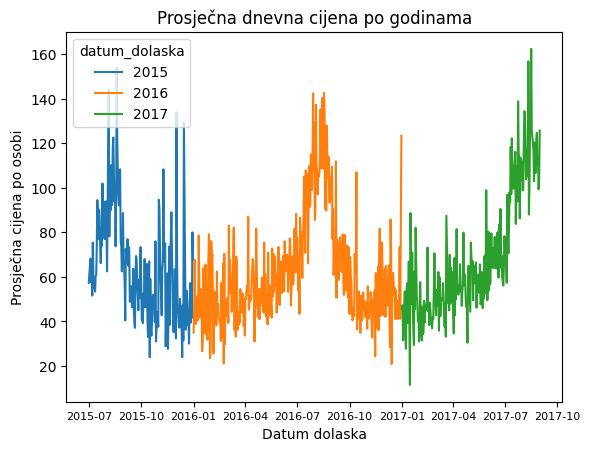

<Figure size 1200x600 with 0 Axes>

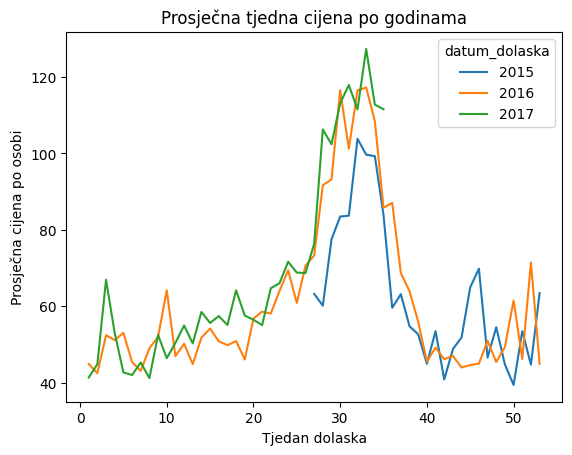

<Figure size 1200x600 with 0 Axes>

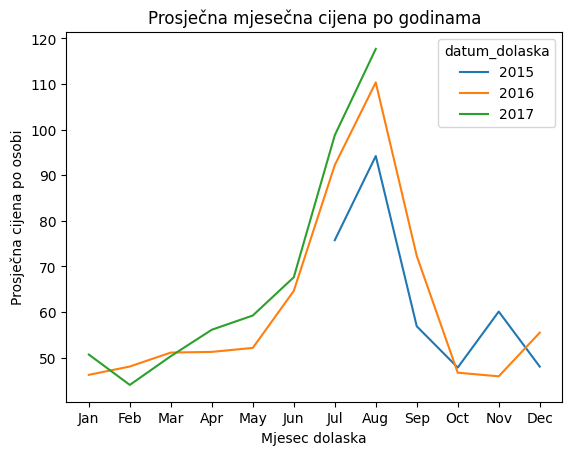

In [26]:
plt.figure(figsize=(12,6))
average_daily_price.unstack(level=0).plot()  
plt.title('Prosječna dnevna cijena po godinama')
plt.xlabel('Datum dolaska')
plt.xticks(fontsize=8)
plt.ylabel('Prosječna cijena po osobi')
plt.show()

plt.figure(figsize=(12,6))
average_weekly_price.unstack(level=0).plot()
plt.title('Prosječna tjedna cijena po godinama')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Prosječna cijena po osobi')
plt.show()

plt.figure(figsize=(12,6))
average_monthly_price.unstack(level=0).plot()  
plt.title('Prosječna mjesečna cijena po godinama')
plt.xlabel('Mjesec dolaska')
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.ylabel('Prosječna cijena po osobi')
plt.show()

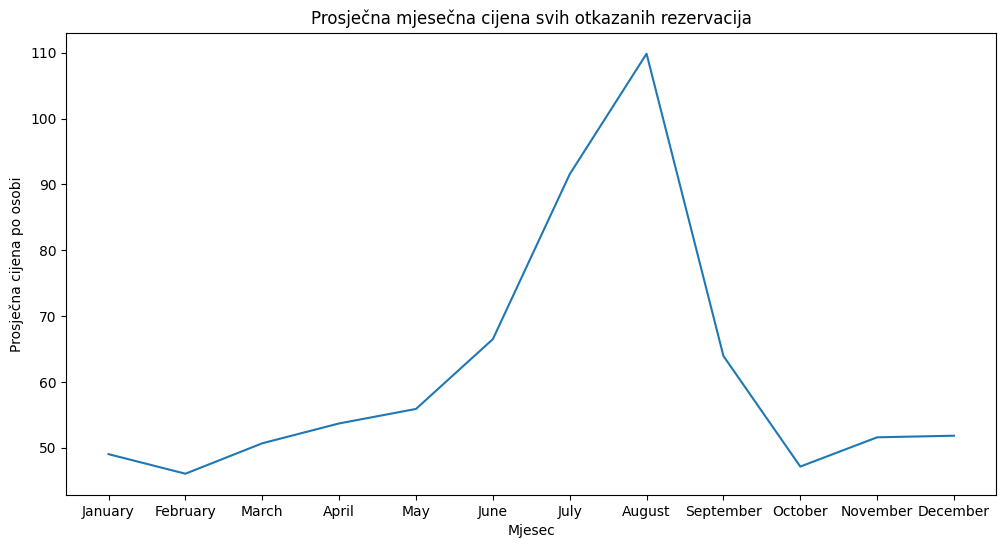

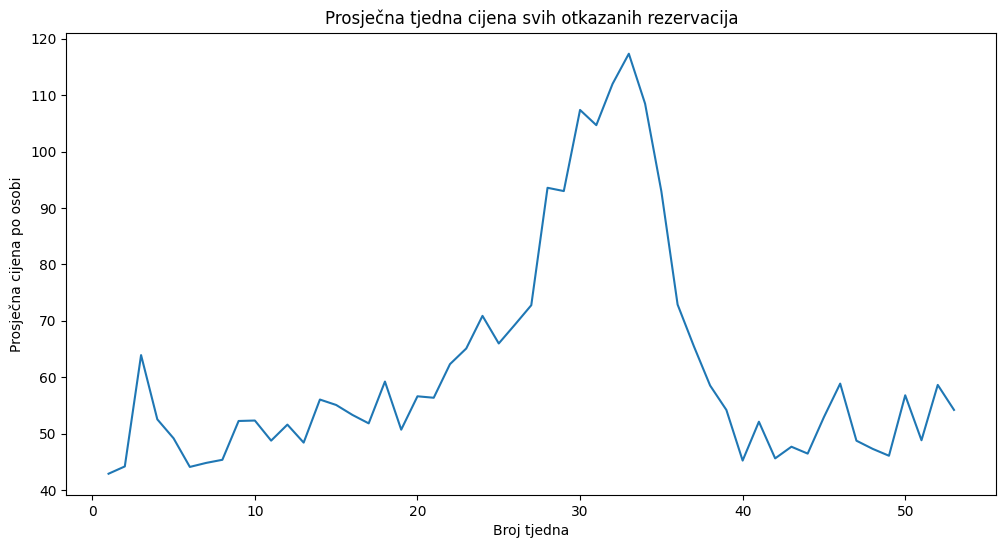

In [27]:
month_names = [calendar.month_name[i] for i in range(1, 13)]

plt.figure(figsize=(12, 6))
overall_average_monthly_price.plot()
plt.title('Prosječna mjesečna cijena svih otkazanih rezervacija')
plt.xticks(range(1, 13), [calendar.month_name[i] for i in range(1, 13)])  
plt.xlabel('Mjesec')
plt.ylabel('Prosječna cijena po osobi')
plt.show()

plt.figure(figsize=(12, 6))
overall_average_weekly_price.plot()
plt.title('Prosječna tjedna cijena svih otkazanih rezervacija')
plt.xlabel('Broj tjedna')
plt.ylabel('Prosječna cijena po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

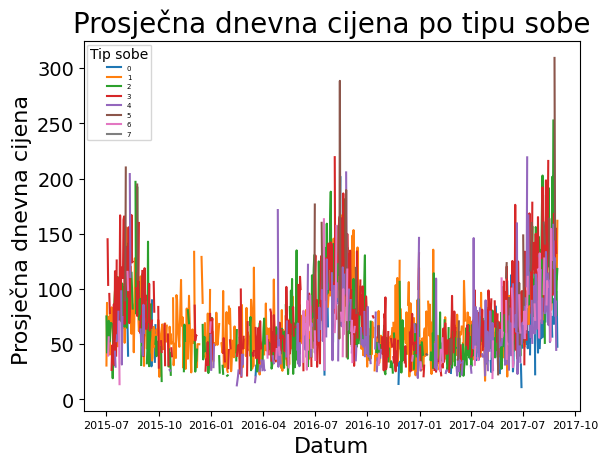

In [28]:
plt.figure(figsize=(28, 20))
average_by_daily_room_type.unstack(level=1).plot() 
plt.title('Prosječna dnevna cijena po tipu sobe', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosječna dnevna cijena ', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=5)
plt.show()


<Figure size 2800x2000 with 0 Axes>

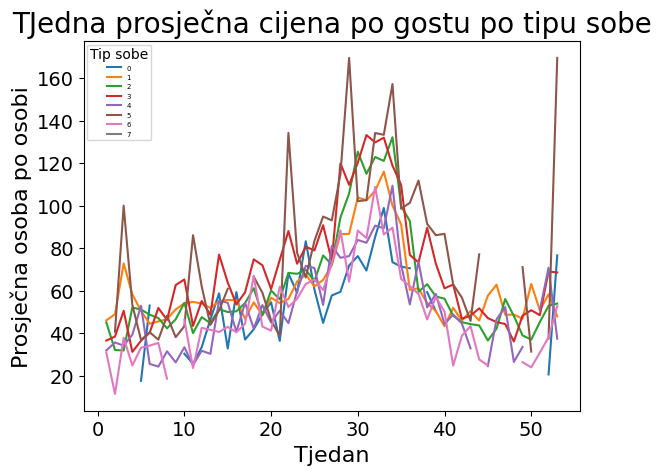

In [29]:
plt.figure(figsize=(28, 20))
average_by_weekly_room_type.unstack(level=1).plot()  
plt.title('TJedna prosječna cijena po gostu po tipu sobe', fontsize=20)
plt.xlabel('Tjedan', fontsize=16)
plt.ylabel('Prosječna osoba po osobi', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=5)
plt.show()



<Figure size 2800x2000 with 0 Axes>

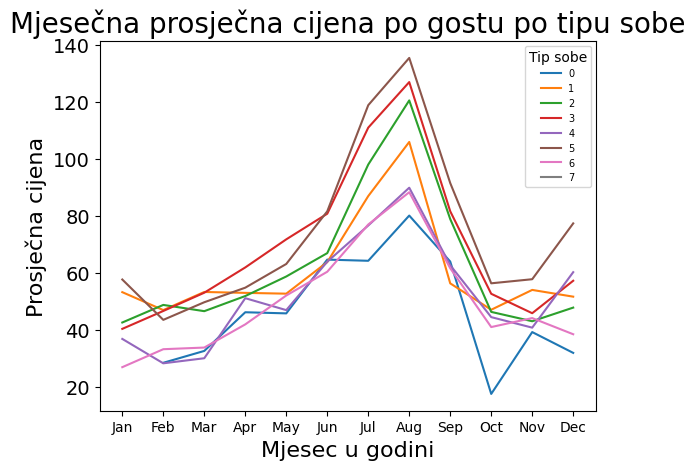

In [30]:
plt.figure(figsize=(28, 20))
average_by_monthly_room_type.unstack(level=1).plot() 
plt.title('Mjesečna prosječna cijena po gostu po tipu sobe', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosječna cijena', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=7)
plt.show()


<Figure size 2800x2000 with 0 Axes>

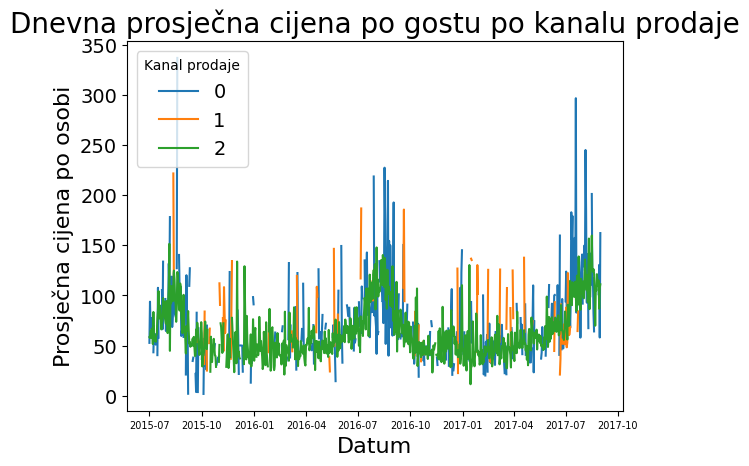

In [31]:
plt.figure(figsize=(28, 20))
average_by_daily_sales_channel.unstack(level=1).plot()  
plt.title('Dnevna prosječna cijena po gostu po kanalu prodaje', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosječna cijena po osobi', fontsize=16)
plt.xticks(fontsize=7)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

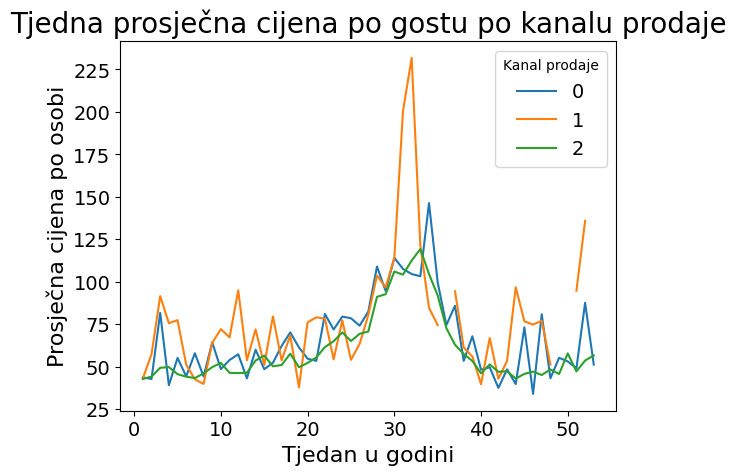

In [32]:
plt.figure(figsize=(28, 20))
average_by_weekly_sales_channel.unstack(level=1).plot()
plt.title('Tjedna prosječna cijena po gostu po kanalu prodaje', fontsize=20)
plt.xlabel('Tjedan u godini', fontsize=16)
plt.ylabel('Prosječna cijena po osobi', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

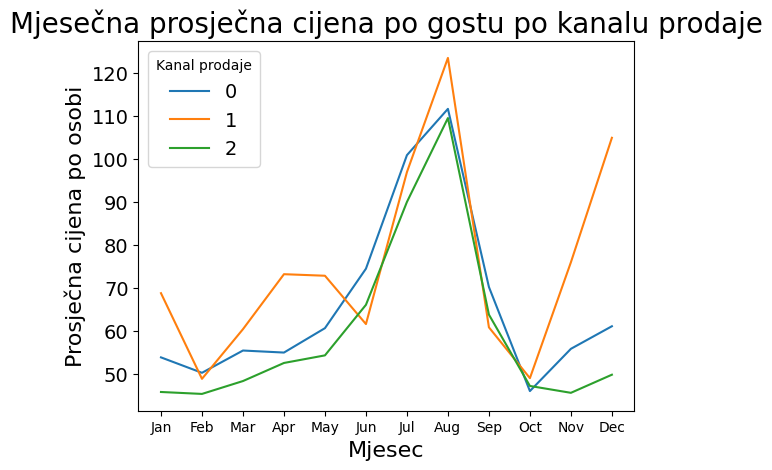

In [33]:
plt.figure(figsize=(28, 20))
average_by_monthly_sales_channel.unstack(level=1).plot()  
plt.title('Mjesečna prosječna cijena po gostu po kanalu prodaje', fontsize=20)
plt.xlabel('Mjesec', fontsize=16)
plt.ylabel('Prosječna cijena po osobi', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()



### HOTEL Resort  ostvareni dolasci

<Figure size 2800x2000 with 0 Axes>

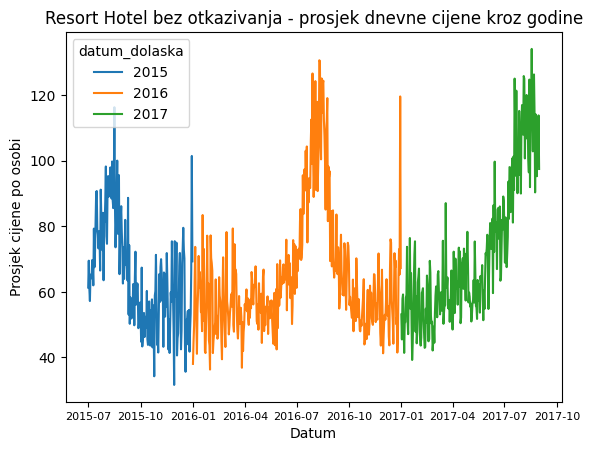

In [34]:
plt.figure(figsize=(28, 20))
average_daily_price_hotel_resort_no.unstack(level=0).plot()
plt.title('Resort Hotel bez otkazivanja - prosjek dnevne cijene kroz godine')
plt.xlabel('Datum')
plt.xticks(fontsize=8)
plt.ylabel('Prosjek cijene po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

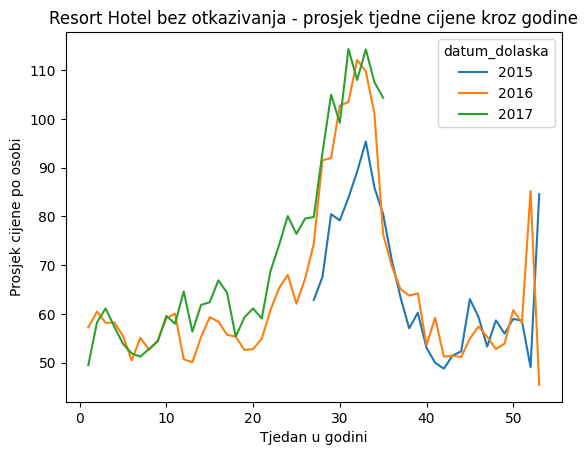

In [35]:
plt.figure(figsize=(28, 20))
average_weekly_price_hotel_resort_no.unstack(level=0).plot()
plt.title('Resort Hotel bez otkazivanja - prosjek tjedne cijene kroz godine')
plt.xlabel('Tjedan u godini')
plt.ylabel('Prosjek cijene po osobi')
plt.show()

<Figure size 2800x2000 with 0 Axes>

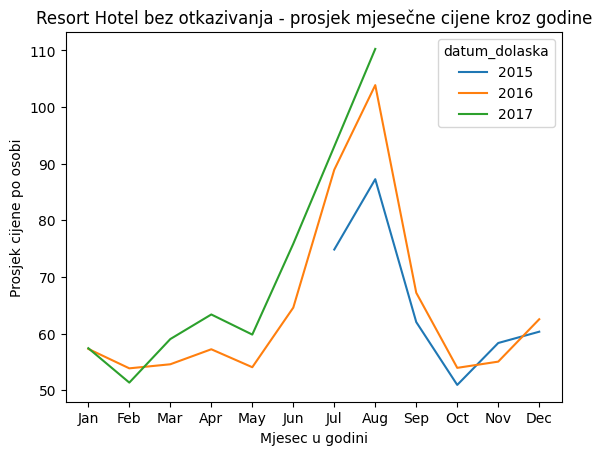

In [36]:
plt.figure(figsize=(28, 20))
average_monthly_price_hotel_resort_no.unstack(level=0).plot()
plt.title('Resort Hotel bez otkazivanja - prosjek mjesečne cijene kroz godine')
plt.xlabel('Mjesec u godini')
plt.ylabel('Prosjek cijene po osobi')
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.show()


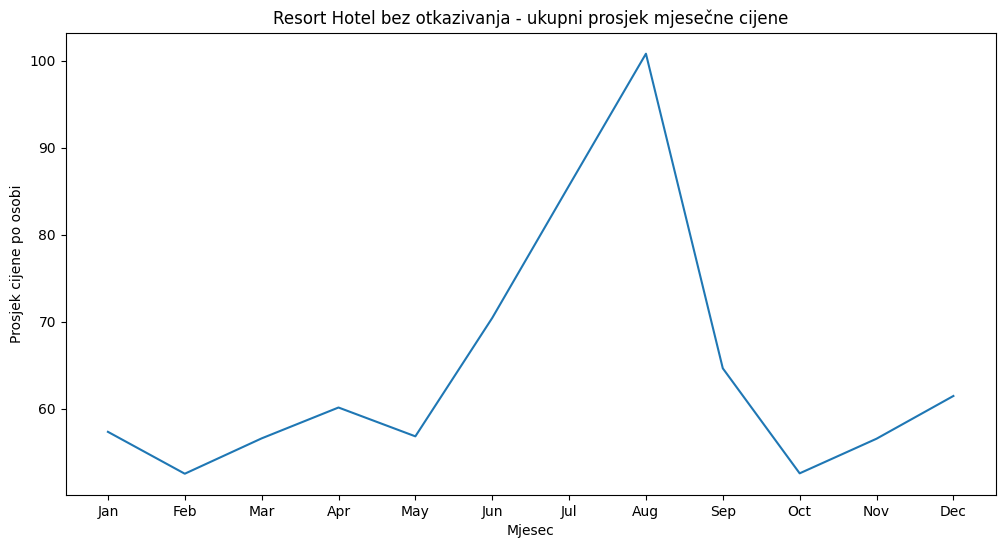

In [37]:
plt.figure(figsize=(12, 6))
overall_average_monthly_price_hotel_resort_no.plot()
plt.title('Resort Hotel bez otkazivanja - ukupni prosjek mjesečne cijene')
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.xlabel('Mjesec')
plt.ylabel('Prosjek cijene po osobi')
plt.show()

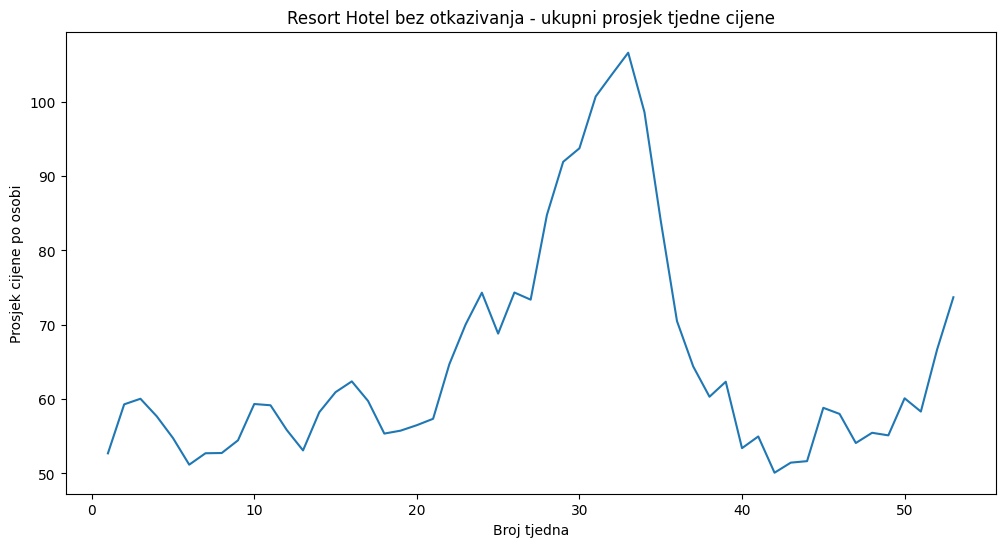

In [38]:
plt.figure(figsize=(12, 6))
overall_average_weekly_price_hotel_resort_no.plot()
plt.title('Resort Hotel bez otkazivanja - ukupni prosjek tjedne cijene')
plt.xlabel('Broj tjedna')
plt.ylabel('Prosjek cijene po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

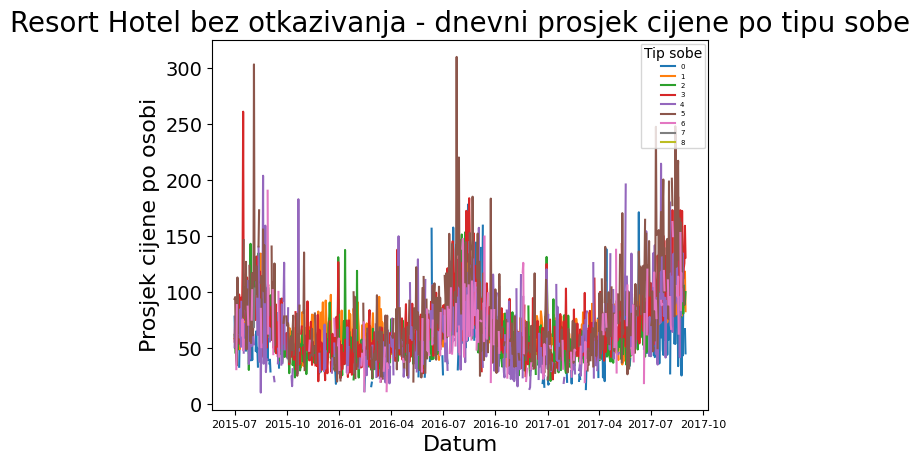

In [39]:
plt.figure(figsize=(28, 20))
average_by_daily_room_type_hotel_resort_no.unstack(level=1).plot()
plt.title('Resort Hotel bez otkazivanja - dnevni prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=5)
plt.show()


<Figure size 2800x2000 with 0 Axes>

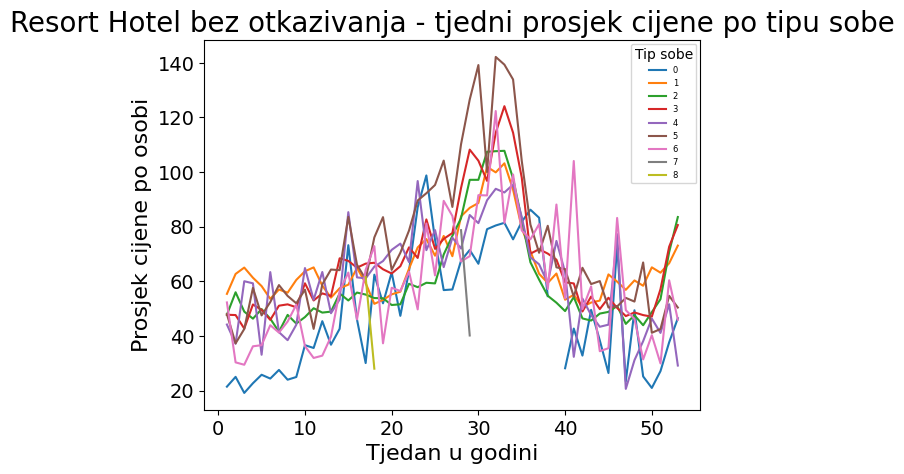

In [40]:
plt.figure(figsize=(28, 20))
average_by_weekly_room_type_hotel_resort_no.unstack(level=1).plot()
plt.title('Resort Hotel bez otkazivanja - tjedni prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Tjedan u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=6)
plt.show()

<Figure size 2800x2000 with 0 Axes>

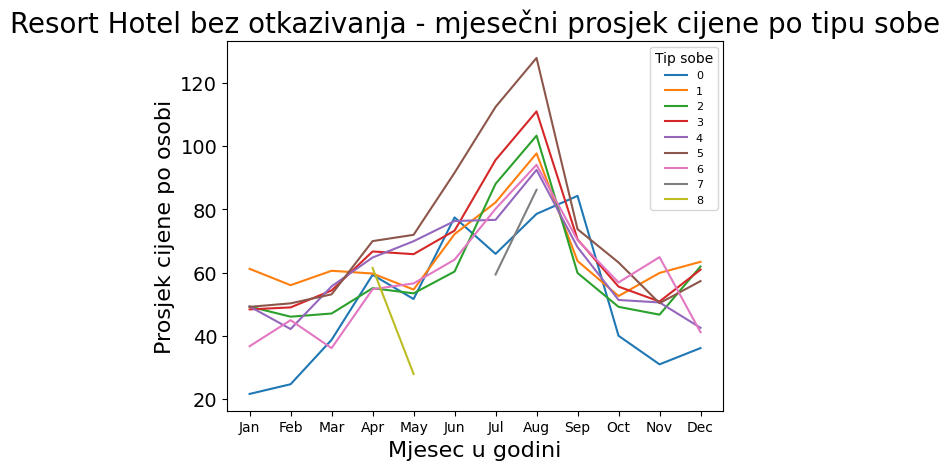

In [41]:
plt.figure(figsize=(28, 20))
average_by_monthly_room_type_hotel_resort_no.unstack(level=1).plot()
plt.title('Resort Hotel bez otkazivanja - mjesečni prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=8)
plt.show()

<Figure size 2800x2000 with 0 Axes>

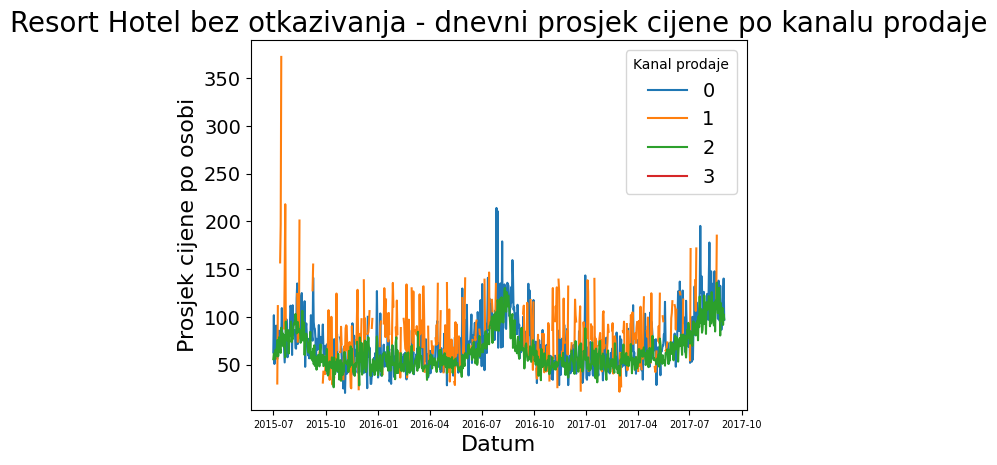

In [42]:
plt.figure(figsize=(28, 20))
average_by_daily_sales_channel_hotel_resort_no.unstack(level=1).plot()
plt.title('Resort Hotel bez otkazivanja - dnevni prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=7)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

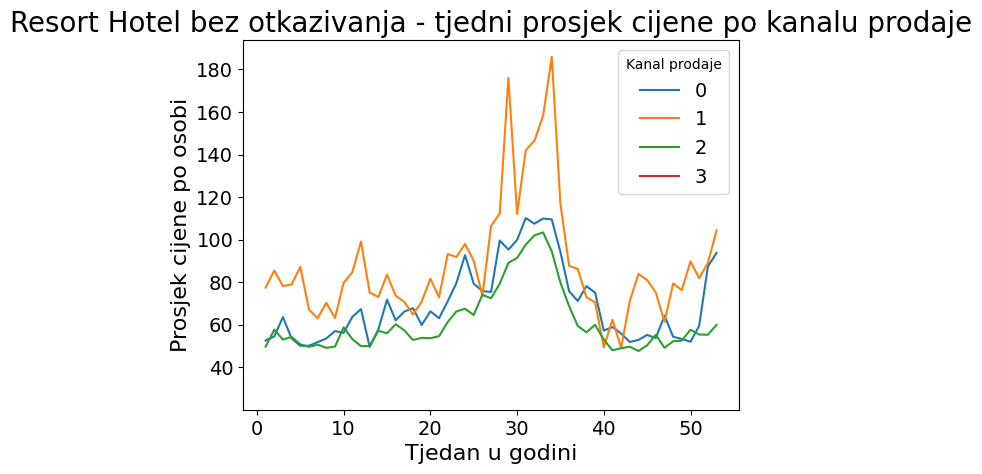

In [43]:
plt.figure(figsize=(28, 20))
average_by_weekly_sales_channel_hotel_resort_no.unstack(level=1).plot()
plt.title('Resort Hotel bez otkazivanja - tjedni prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Tjedan u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()

<Figure size 2800x2000 with 0 Axes>

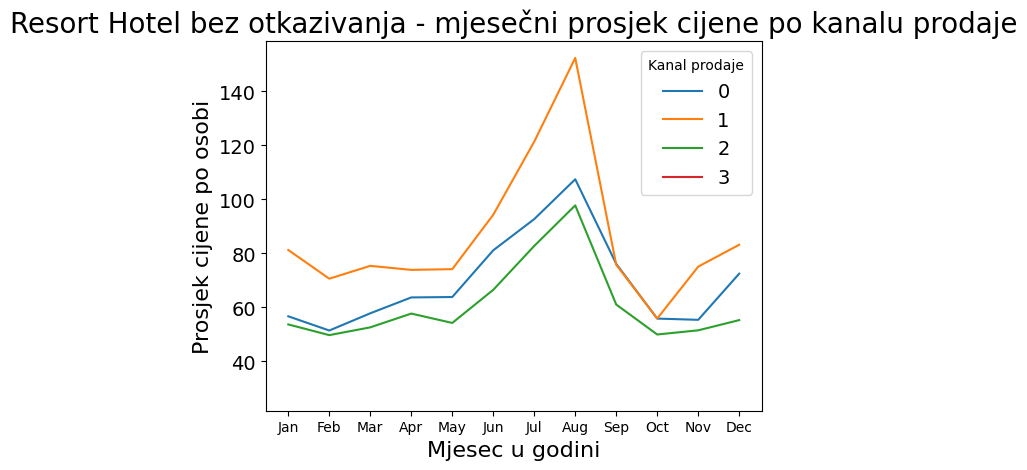

In [44]:
plt.figure(figsize=(28, 20))
average_by_monthly_sales_channel_hotel_resort_no.unstack(level=1).plot()
plt.title('Resort Hotel bez otkazivanja - mjesečni prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()

### HOTEL 1 otkazani dolasci

<Figure size 2800x2000 with 0 Axes>

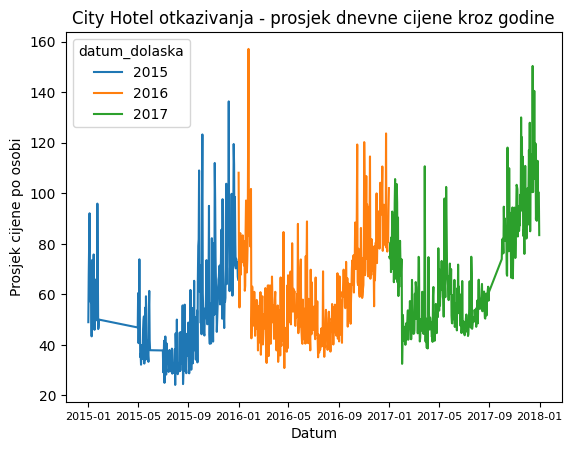

In [45]:
plt.figure(figsize=(28, 20))
average_daily_price_hotel_city.unstack(level=0).plot()
plt.title('City Hotel otkazivanja - prosjek dnevne cijene kroz godine')
plt.xlabel('Datum')
plt.xticks(fontsize=8)
plt.ylabel('Prosjek cijene po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

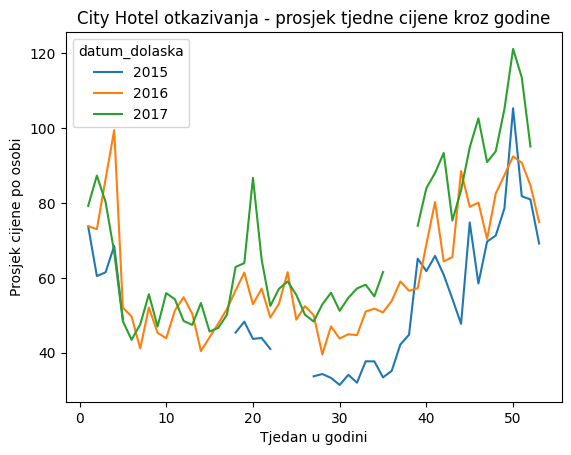

In [46]:
plt.figure(figsize=(28, 20))
average_weekly_price_hotel_city.unstack(level=0).plot()
plt.title('City Hotel otkazivanja - prosjek tjedne cijene kroz godine')
plt.xlabel('Tjedan u godini')
plt.ylabel('Prosjek cijene po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

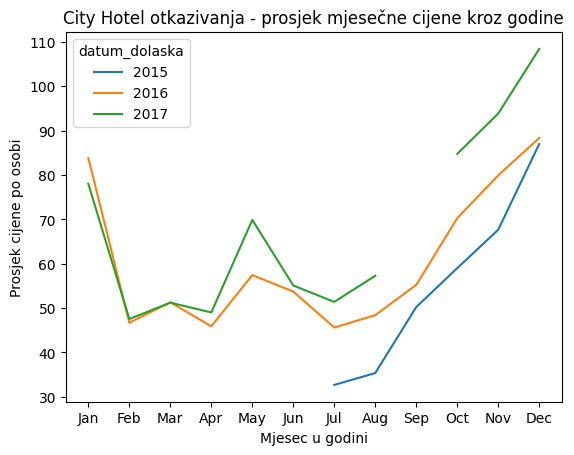

In [47]:
plt.figure(figsize=(28, 20))
average_monthly_price_hotel_city.unstack(level=0).plot()
plt.title('City Hotel otkazivanja - prosjek mjesečne cijene kroz godine')
plt.xlabel('Mjesec u godini')
plt.ylabel('Prosjek cijene po osobi')
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.show()


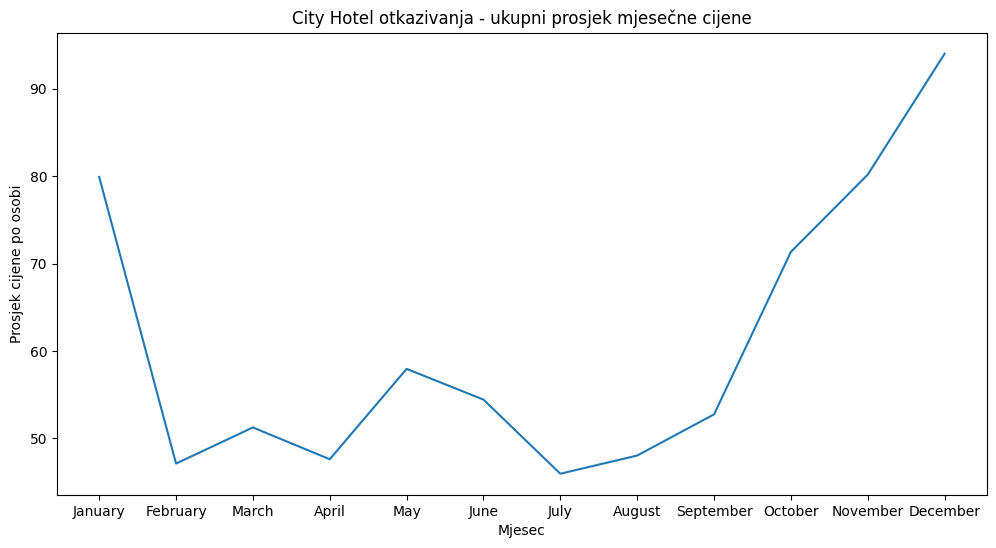

In [48]:
plt.figure(figsize=(12, 6))
overall_average_monthly_price_hotel_city.plot()
plt.title('City Hotel otkazivanja - ukupni prosjek mjesečne cijene')
plt.xticks(range(1, 13), [calendar.month_name[i] for i in range(1, 13)])
plt.xlabel('Mjesec')
plt.ylabel('Prosjek cijene po osobi')
plt.show()

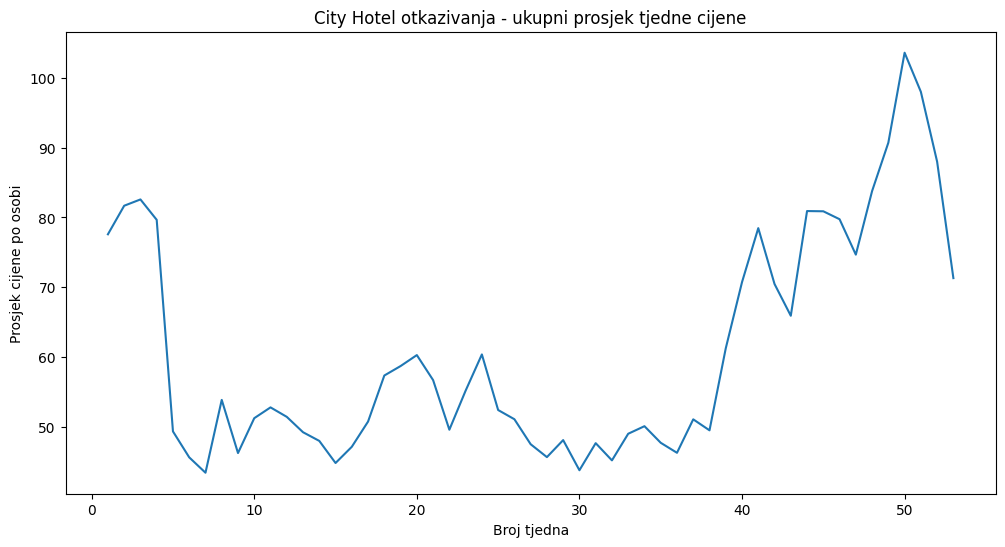

In [49]:
plt.figure(figsize=(12, 6))
overall_average_weekly_price_hotel_city.plot()
plt.title('City Hotel otkazivanja - ukupni prosjek tjedne cijene')
plt.xlabel('Broj tjedna')
plt.ylabel('Prosjek cijene po osobi')
plt.show()

<Figure size 2800x2000 with 0 Axes>

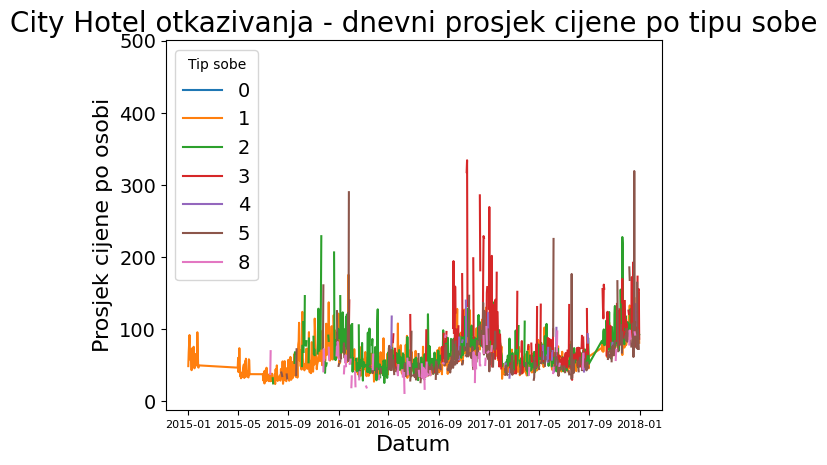

In [50]:
plt.figure(figsize=(28, 20))
average_by_daily_room_type_hotel_city.unstack(level=1).plot()
plt.title('City Hotel otkazivanja - dnevni prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=14)
plt.show()

<Figure size 2800x2000 with 0 Axes>

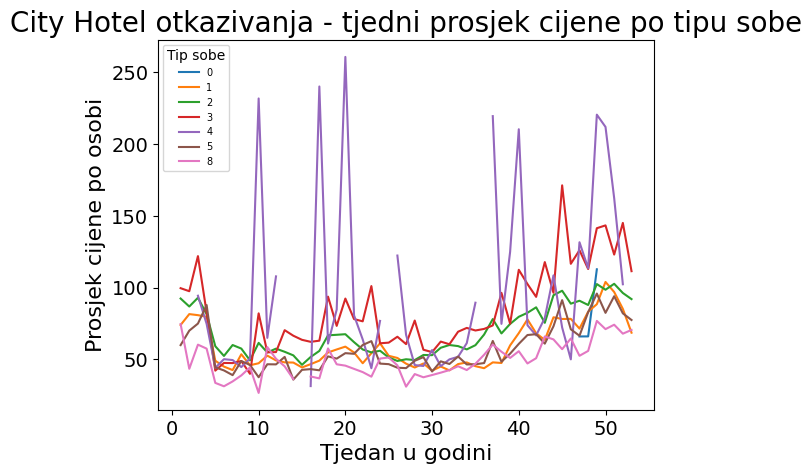

In [51]:
plt.figure(figsize=(28, 20))
average_by_weekly_room_type_hotel_city.unstack(level=1).plot()
plt.title('City Hotel otkazivanja - tjedni prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Tjedan u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=7)
plt.show()

<Figure size 2800x2000 with 0 Axes>

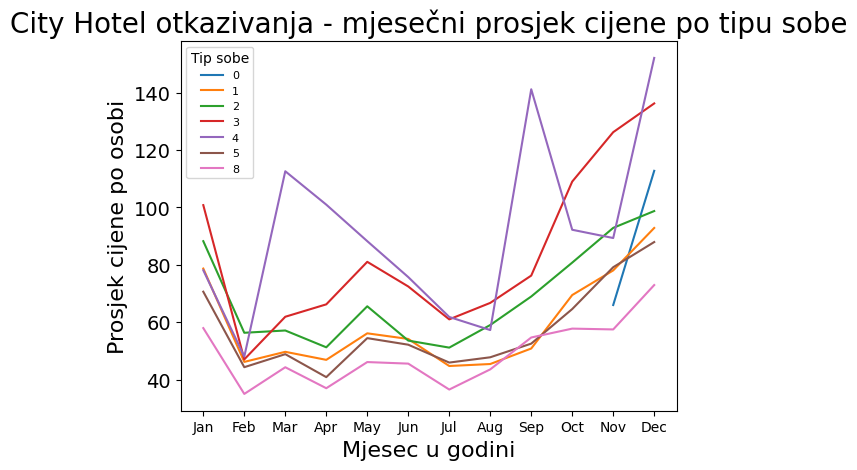

In [52]:
plt.figure(figsize=(28, 20))
average_by_monthly_room_type_hotel_city.unstack(level=1).plot()
plt.title('City Hotel otkazivanja - mjesečni prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=8)
plt.show()

<Figure size 2800x2000 with 0 Axes>

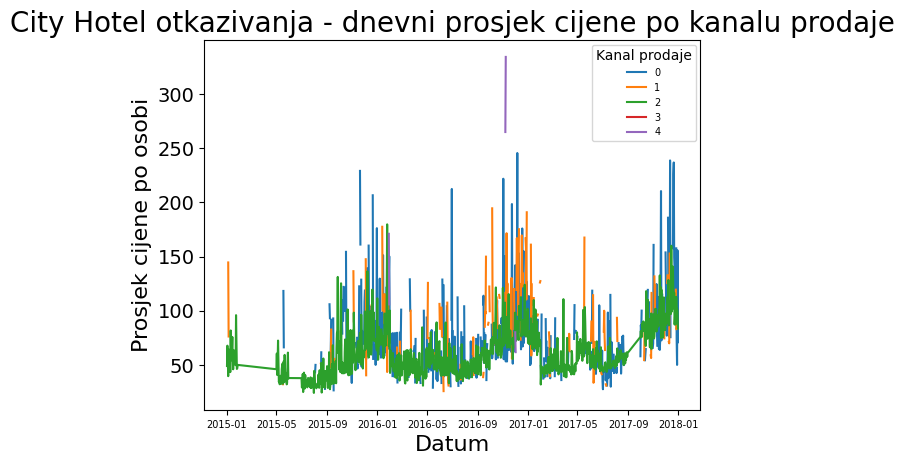

In [53]:
plt.figure(figsize=(28, 20))
average_by_daily_sales_channel_hotel_city.unstack(level=1).plot()
plt.title('City Hotel otkazivanja - dnevni prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=7)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=7)
plt.show()

<Figure size 2800x2000 with 0 Axes>

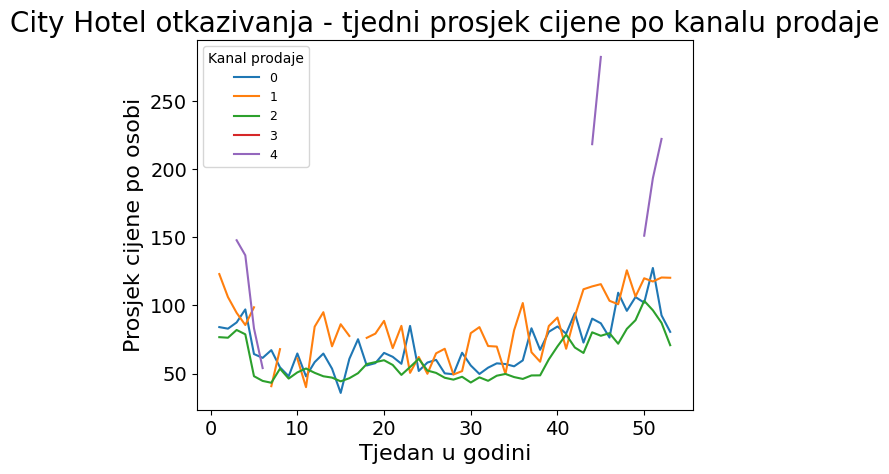

In [54]:
plt.figure(figsize=(28, 20))
average_by_weekly_sales_channel_hotel_city.unstack(level=1).plot()
plt.title('City Hotel otkazivanja - tjedni prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Tjedan u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=9)
plt.show()

<Figure size 2800x2000 with 0 Axes>

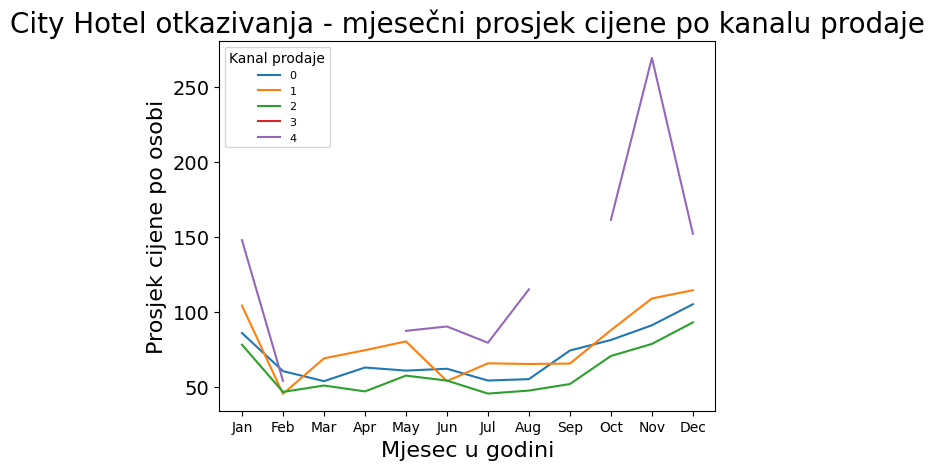

In [55]:
plt.figure(figsize=(28, 20))
average_by_monthly_sales_channel_hotel_city.unstack(level=1).plot()
plt.title('City Hotel otkazivanja - mjesečni prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=8)
plt.show()

### HOTEL 1 ostvareni dolasci

<Figure size 2800x2000 with 0 Axes>

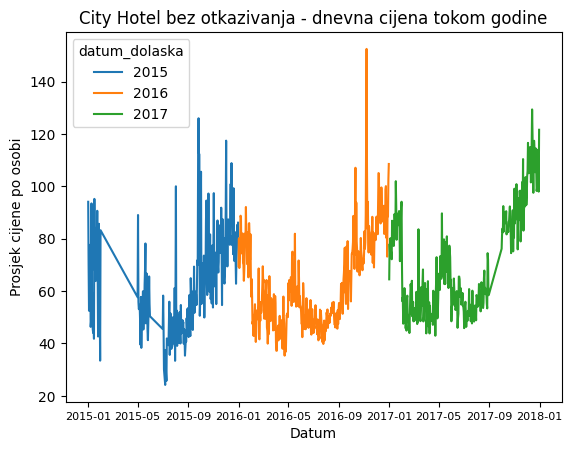

In [56]:
plt.figure(figsize=(28, 20))
average_daily_price_hotel_city_no.unstack(level=0).plot()
plt.title('City Hotel bez otkazivanja - dnevna cijena tokom godine')
plt.xlabel('Datum')
plt.xticks(fontsize=8)
plt.ylabel('Prosjek cijene po osobi')
plt.show()

<Figure size 2800x2000 with 0 Axes>

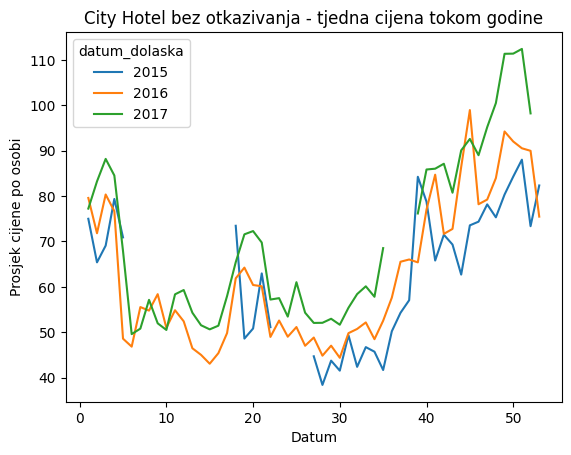

In [57]:
plt.figure(figsize=(28, 20))
average_weekly_price_hotel_city_no.unstack(level=0).plot()
plt.title('City Hotel bez otkazivanja - tjedna cijena tokom godine')
plt.xlabel('Datum')
plt.ylabel('Prosjek cijene po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

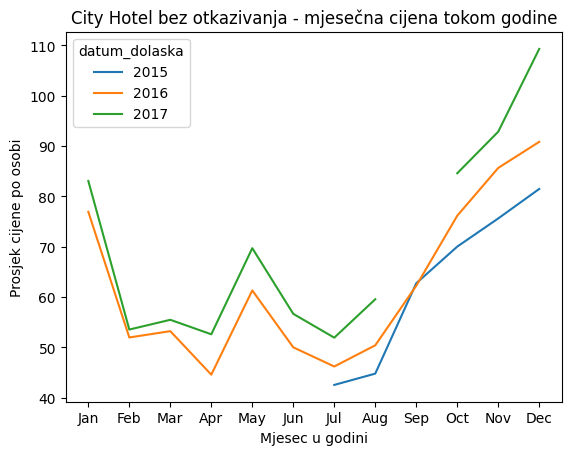

In [58]:
plt.figure(figsize=(28, 20))
average_monthly_price_hotel_city_no.unstack(level=0).plot()
plt.title('City Hotel bez otkazivanja - mjesečna cijena tokom godine')
plt.xlabel('Mjesec u godini')
plt.ylabel('Prosjek cijene po osobi')
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.show()

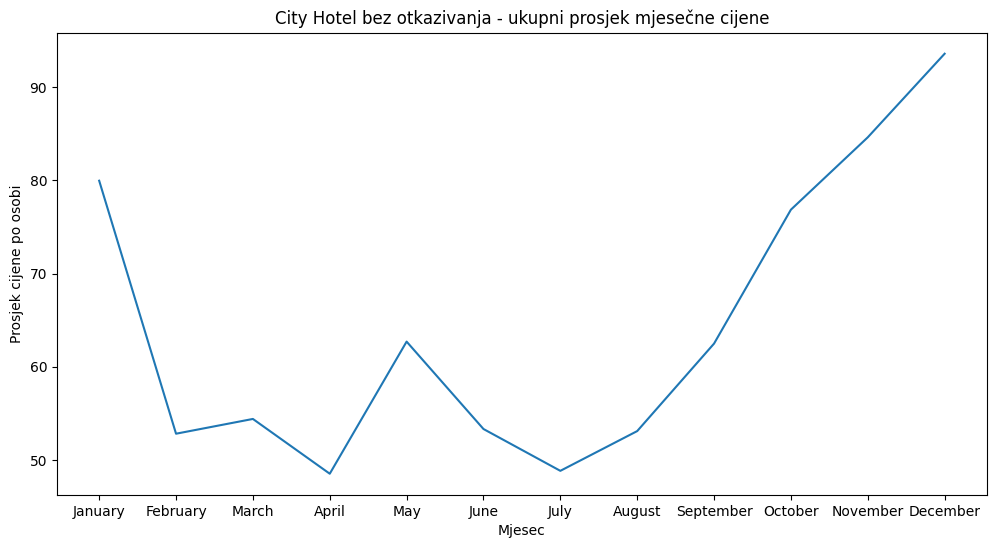

In [59]:
plt.figure(figsize=(12, 6))
overall_average_monthly_price_hotel_city_no.plot()
plt.title('City Hotel bez otkazivanja - ukupni prosjek mjesečne cijene')
plt.xticks(range(1, 13), [calendar.month_name[i] for i in range(1, 13)])
plt.xlabel('Mjesec')
plt.ylabel('Prosjek cijene po osobi')
plt.show()


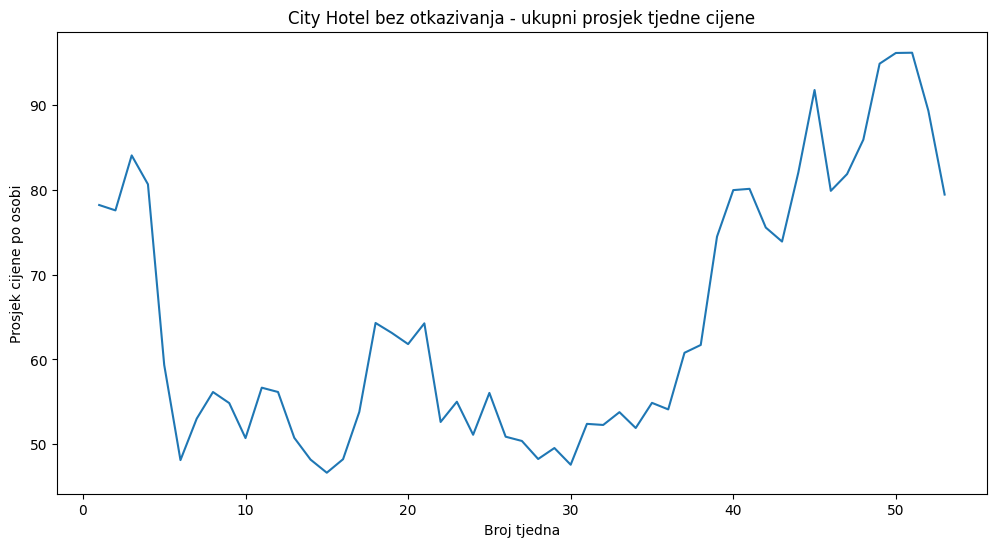

In [60]:
plt.figure(figsize=(12, 6))
overall_average_weekly_price_hotel_city_no.plot()
plt.title('City Hotel bez otkazivanja - ukupni prosjek tjedne cijene')
plt.xlabel('Broj tjedna')
plt.ylabel('Prosjek cijene po osobi')
plt.show()



<Figure size 2800x2000 with 0 Axes>

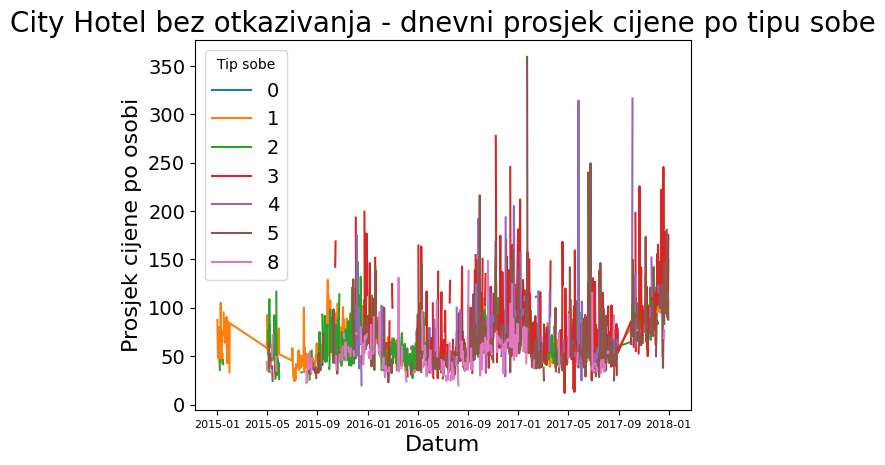

In [61]:
plt.figure(figsize=(28, 20))
average_by_daily_room_type_hotel_city_no.unstack(level=1).plot()
plt.title('City Hotel bez otkazivanja - dnevni prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=14)
plt.show()




<Figure size 2800x2000 with 0 Axes>

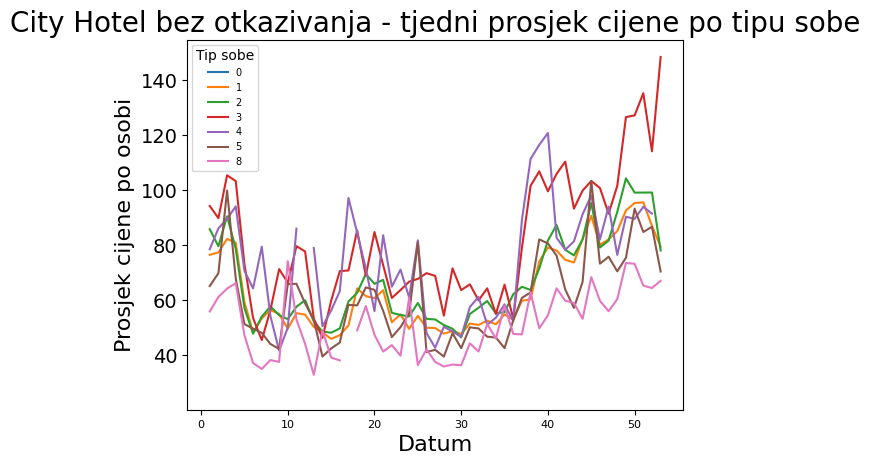

In [62]:
plt.figure(figsize=(28, 20))
average_by_weekly_room_type_hotel_city_no.unstack(level=1).plot()
plt.title('City Hotel bez otkazivanja - tjedni prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=7)
plt.show()





<Figure size 2800x2000 with 0 Axes>

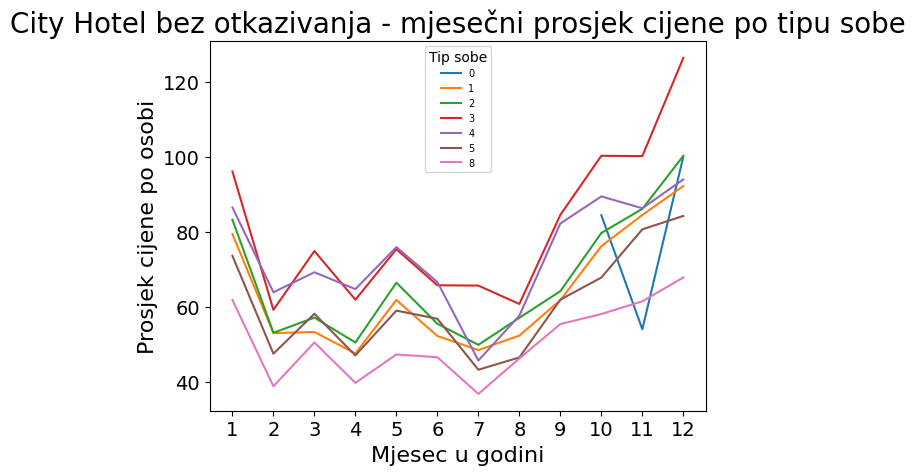

In [63]:
plt.figure(figsize=(28, 20))
average_by_monthly_room_type_hotel_city_no.unstack(level=1).plot()
plt.title('City Hotel bez otkazivanja - mjesečni prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=7)
plt.show()





<Figure size 2800x2000 with 0 Axes>

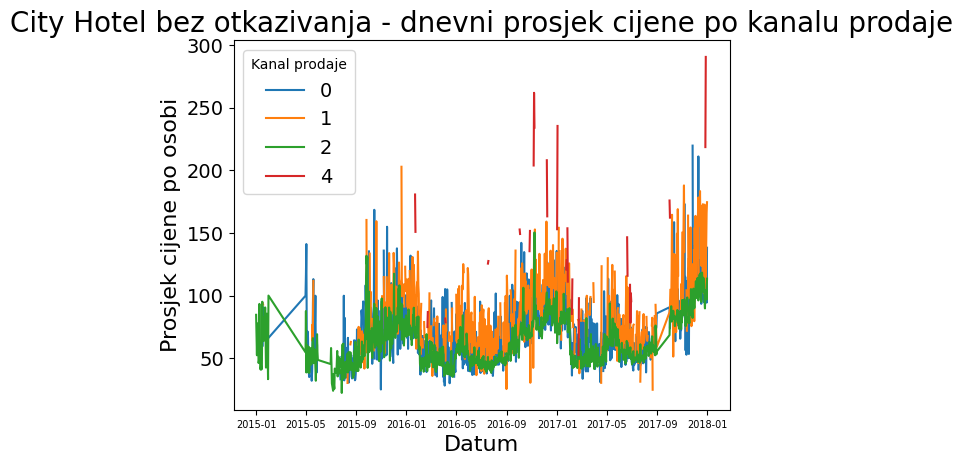

In [64]:
plt.figure(figsize=(28, 20))
average_by_daily_sales_channel_hotel_city_no.unstack(level=1).plot()
plt.title('City Hotel bez otkazivanja - dnevni prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=7)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()

<Figure size 2800x2000 with 0 Axes>

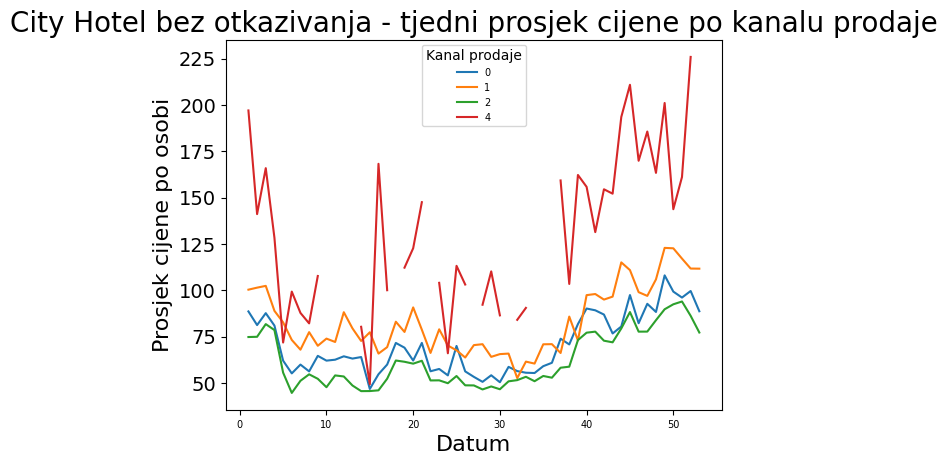

In [65]:
plt.figure(figsize=(28, 20))
average_by_weekly_sales_channel_hotel_city_no.unstack(level=1).plot()
plt.title('City Hotel bez otkazivanja - tjedni prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=7)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=7)
plt.show()

<Figure size 2800x2000 with 0 Axes>

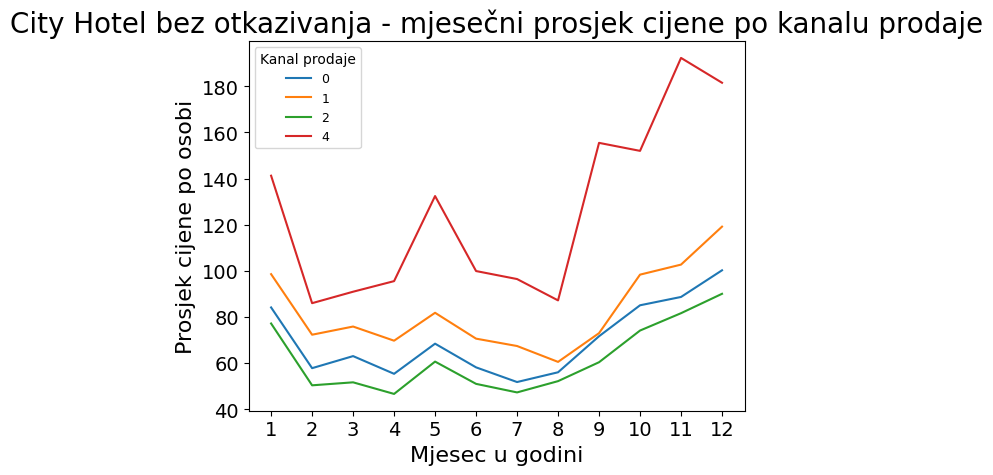

In [66]:
plt.figure(figsize=(28, 20))
average_by_monthly_sales_channel_hotel_city_no.unstack(level=1).plot()
plt.title('City Hotel bez otkazivanja - mjesečni prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=9)
plt.show()

# Ostale analize i vizuali

### Zanimaju nas zemlje podrijetla gostiju

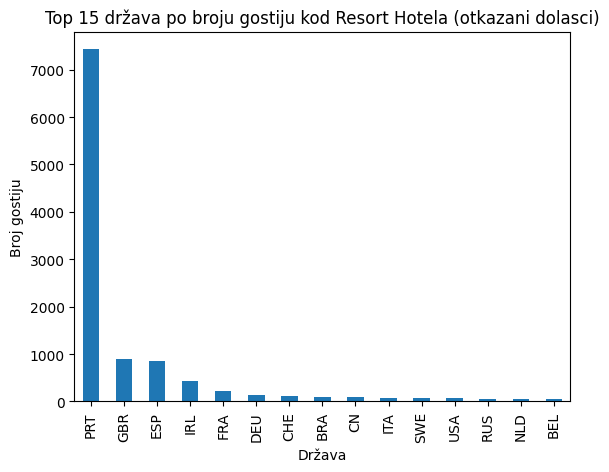

In [67]:
n = 15
top_countries_cancel_resort = hotel_resort_cancellations['zemlja_gosta'].value_counts()[0:n]
top_countries_cancel_resort.plot(kind='bar')
plt.title(f'Top {n} država po broju gostiju kod Resort Hotela (otkazani dolasci)')
plt.xlabel('Država')
plt.ylabel('Broj gostiju')
plt.show()

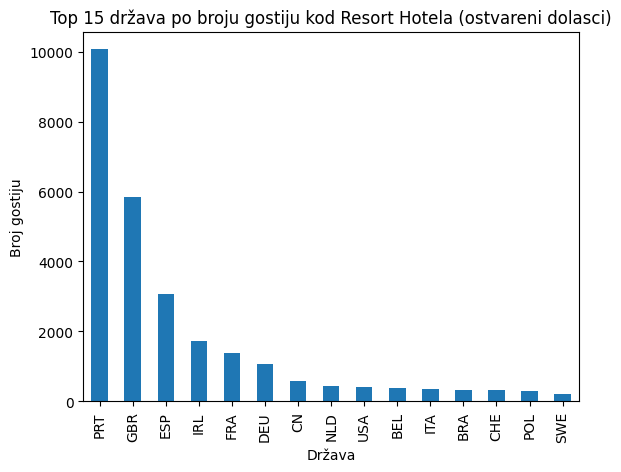

In [68]:
n = 15
top_countries_no_cancel_resort = hotel_resort_no_cancellations['zemlja_gosta'].value_counts()[0:n]
top_countries_no_cancel_resort.plot(kind='bar')
plt.title(f'Top {n} država po broju gostiju kod Resort Hotela (ostvareni dolasci)')
plt.xlabel('Država')
plt.ylabel('Broj gostiju')
plt.show()

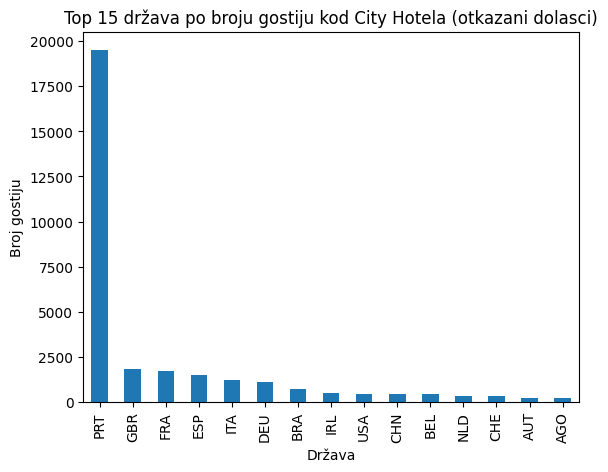

In [69]:
n = 15
top_countries_cancel_city = hotel_city_cancellations['zemlja_gosta'].value_counts()[0:n]
top_countries_cancel_city.plot(kind='bar')
plt.title(f'Top {n} država po broju gostiju kod City Hotela (otkazani dolasci)')
plt.xlabel('Država')
plt.ylabel('Broj gostiju')
plt.show()

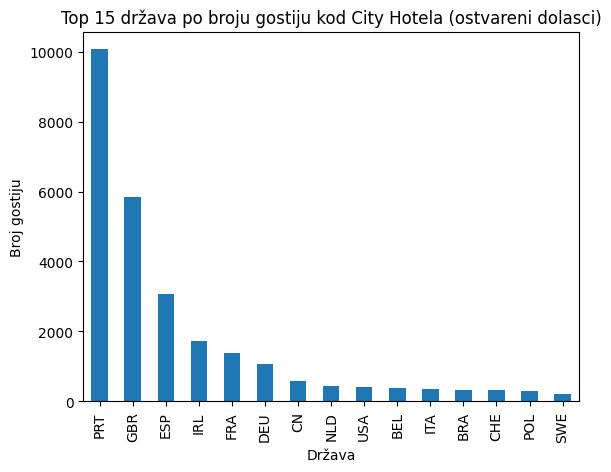

In [70]:
n = 15
top_countries_no_cancel_city = hotel_resort_no_cancellations['zemlja_gosta'].value_counts()[0:n]
top_countries_no_cancel_city.plot(kind='bar')
plt.title(f'Top {n} država po broju gostiju kod City Hotela (ostvareni dolasci)')
plt.xlabel('Država')
plt.ylabel('Broj gostiju')
plt.show()

In [71]:
min_date = data_no_cancellations['datum_dolaska'].min()
max_date = data_no_cancellations['datum_dolaska'].max()

print(f"Svi zapisi su u razdoblju od {min_date} do {max_date}")

Svi zapisi su u razdoblju od 2015-01-01 00:00:00 do 2017-12-31 00:00:00


### Datumi gdje je datum otkazivanja nakon datuma dolaska

In [72]:
krivi_datumi = data_cancellations[data_cancellations['datum_otkazivanja_rezervacije'] > data_cancellations['datum_dolaska']]
print(f"Ukupno {len(krivi_datumi)} redaka s neispravnim datumima")
print(krivi_datumi.head(3))

Ukupno 1950 redaka s neispravnim datumima
       hotel_id datum_dolaska datum_otkazivanja_rezervacije zemlja_gosta  \
11067         1    2015-01-01                    2015-07-01          PRT   
11072         1    2015-05-02                    2015-06-25          PRT   
11073         1    2015-05-02                    2015-07-02          PRT   

       kanal_prodaje_id  tip_sobe_id  cijena_nocenja  gost_id  ukupno_gostiju  \
11067                 2            1       97.930547  1048285               2   
11072                 2            1       72.739914  1019190               1   
11073                 2            1       81.380511  1001102               2   

       duljina_boravka  raspon_dolazak_rezervacija  
11067                4                           0  
11072                4                         105  
11073                5                          35  


### Vizualizacija ukupnog broja gostiju po danu, tjednu i mjesecu po hotelu

#### City Hotel

##### Dnevna razina

In [73]:
NumberOfGuestsDailyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "daily", "daily_guests.parquet"))
NumberOfArrivalsDailyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "daily", "daily_arrivals.parquet"))
NumberOfNewGuestsDailyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "daily", "daily_new_guests.parquet"))


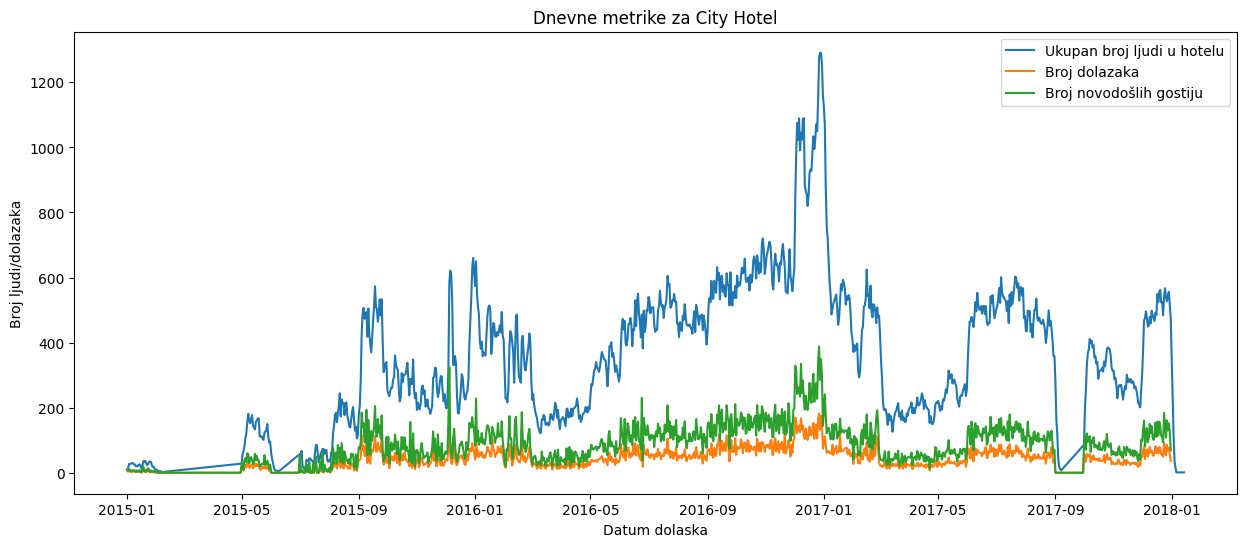

In [74]:
plt.figure(figsize=(15, 6))

plt.plot(NumberOfGuestsDailyCity.index, NumberOfGuestsDailyCity['ukupno_gostiju'], label='Ukupan broj ljudi u hotelu')

plt.plot(NumberOfArrivalsDailyCity.index, NumberOfArrivalsDailyCity['broj_dolazaka'], label='Broj dolazaka')

plt.plot(NumberOfNewGuestsDailyCity.index, NumberOfNewGuestsDailyCity['ukupno_gostiju'], label='Broj novodošlih gostiju')

plt.title('Dnevne metrike za City Hotel')
plt.xlabel('Datum dolaska')
plt.ylabel('Broj ljudi/dolazaka')
plt.legend()

plt.show()

##### Tjedna razina

In [75]:
NumberOfGuestsWeeklyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "weekly", "weekly_guests.parquet"))
NumberOfArrivalsWeeklyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "weekly", "weekly_arrivals.parquet"))
NumberOfNewGuestsWeeklyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "weekly", "weekly_new_guests.parquet"))


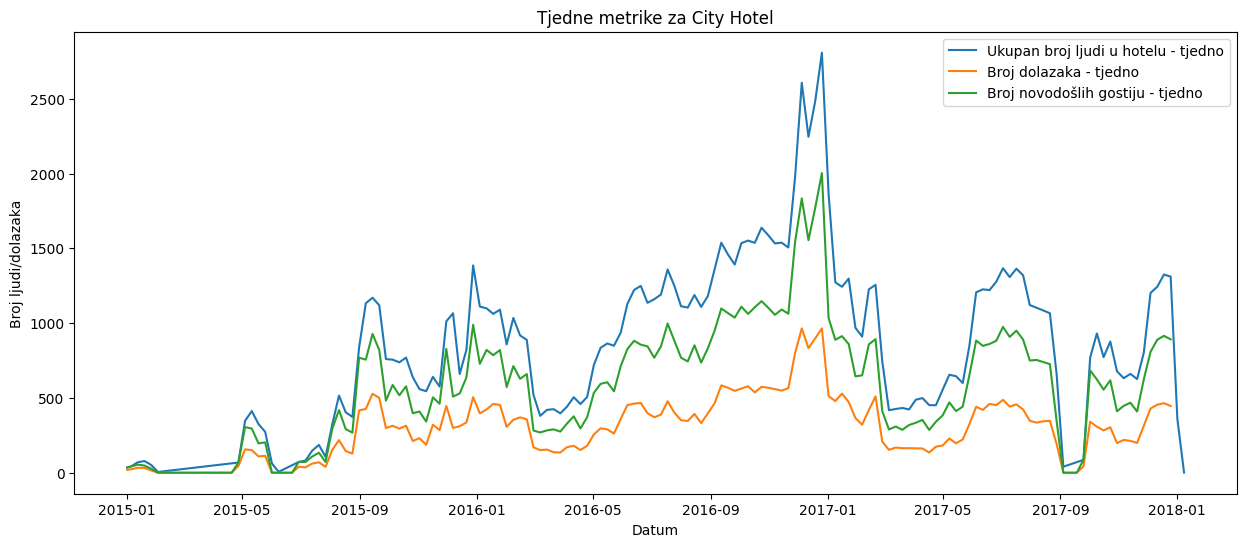

In [76]:
plt.figure(figsize=(15, 6))

plt.plot(NumberOfGuestsWeeklyCity.index, NumberOfGuestsWeeklyCity['ukupno_gostiju'], label='Ukupan broj ljudi u hotelu - tjedno')
plt.plot(NumberOfArrivalsWeeklyCity.index, NumberOfArrivalsWeeklyCity['broj_dolazaka'], label='Broj dolazaka - tjedno')
plt.plot(NumberOfNewGuestsWeeklyCity.index, NumberOfNewGuestsWeeklyCity['ukupno_gostiju'], label='Broj novodošlih gostiju - tjedno')

plt.title('Tjedne metrike za City Hotel')
plt.xlabel('Datum')
plt.ylabel('Broj ljudi/dolazaka')
plt.legend()
plt.show()

##### Crtanje maksimalne i minimalne okupiranosti po tjednu tokom vremena

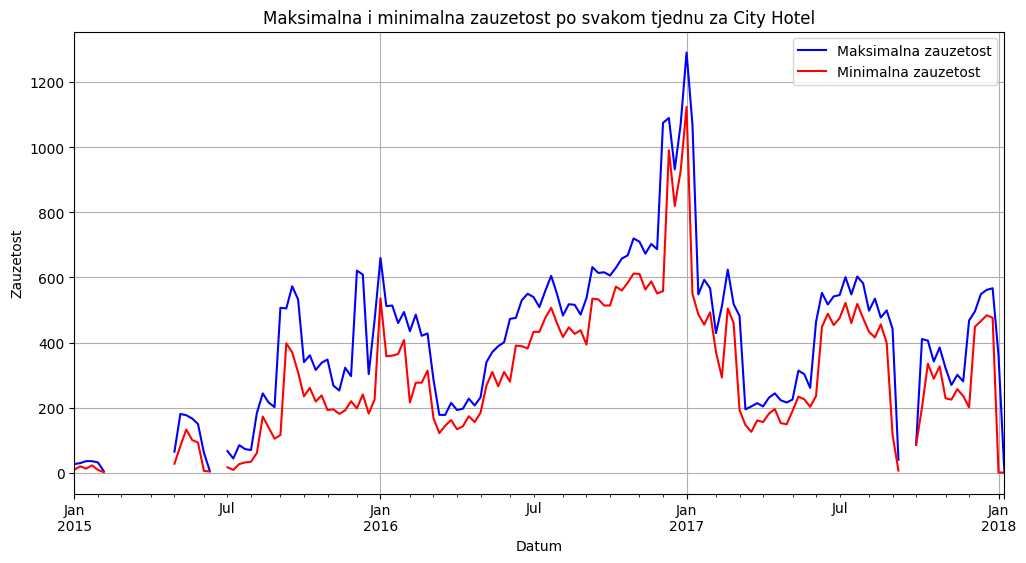

In [77]:
weekly_max = NumberOfGuestsDailyCity['ukupno_gostiju'].resample('W').max()
weekly_min = NumberOfGuestsDailyCity['ukupno_gostiju'].resample('W').min()
weekly_occupancy = pd.DataFrame({'Maksimalna zauzetost': weekly_max, 'Minimalna zauzetost': weekly_min})

plt.figure(figsize=(12, 6))
weekly_occupancy['Maksimalna zauzetost'].plot(color='blue', label='Maksimalna zauzetost')
weekly_occupancy['Minimalna zauzetost'].plot(color='red', label='Minimalna zauzetost')
plt.title('Maksimalna i minimalna zauzetost po svakom tjednu za City Hotel')
plt.xlabel('Datum')
plt.ylabel('Zauzetost')
plt.legend()
plt.grid(True)
plt.show()

##### Mjesečna razina

In [78]:
NumberOfGuestsMonthlyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "monthly", "monthly_guests.parquet"))
NumberOfArrivalsMonthlyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "monthly", "monthly_arrivals.parquet"))
NumberOfNewGuestsMonthlyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "monthly", "monthly_new_guests.parquet"))


In [79]:
NumberOfNewGuestsMonthlyCity.columns

Index(['ukupno_gostiju', 'prosjecna_cijena_po_mjesecu'], dtype='object')

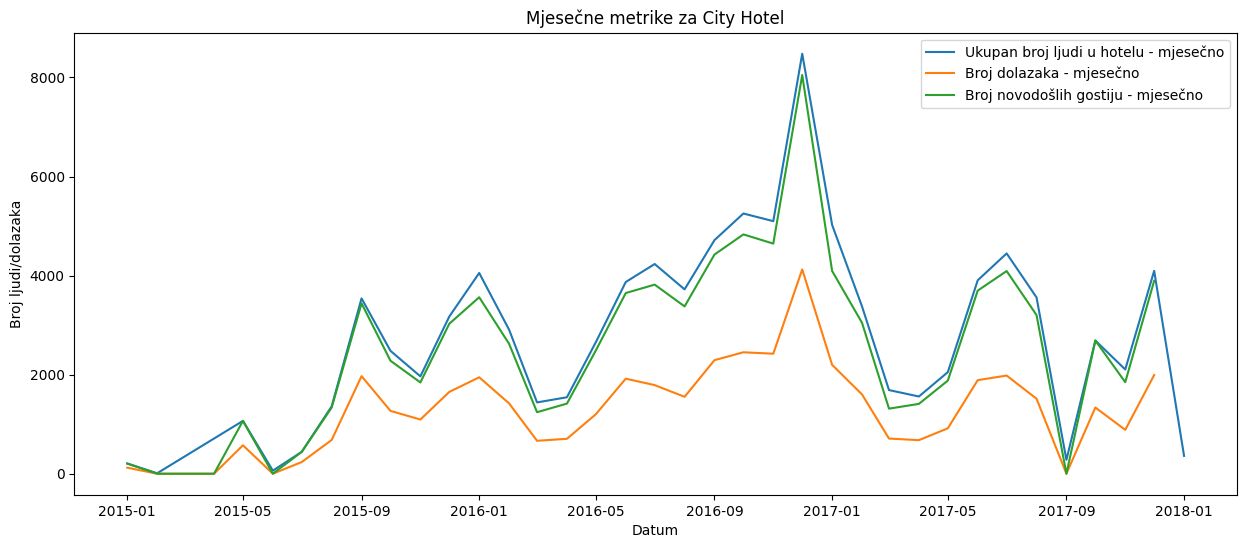

In [80]:
plt.figure(figsize=(15, 6))

plt.plot(NumberOfGuestsMonthlyCity.index, NumberOfGuestsMonthlyCity['ukupno_gostiju'], label='Ukupan broj ljudi u hotelu - mjesečno')
plt.plot(NumberOfArrivalsMonthlyCity.index, NumberOfArrivalsMonthlyCity['broj_dolazaka'], label='Broj dolazaka - mjesečno')
plt.plot(NumberOfNewGuestsMonthlyCity.index, NumberOfNewGuestsMonthlyCity['ukupno_gostiju'], label='Broj novodošlih gostiju - mjesečno')

plt.title('Mjesečne metrike za City Hotel')
plt.xlabel('Datum')
plt.ylabel('Broj ljudi/dolazaka')
plt.legend()
plt.show()


##### Crtanje maksimalne i minimalne okupiranosti po mjesecu tokom vremena

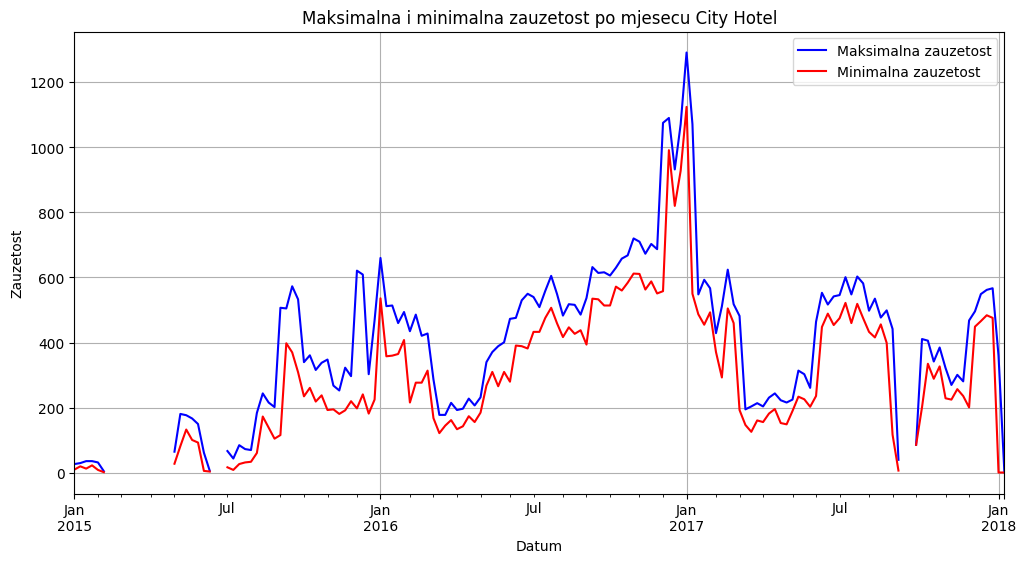

In [81]:
monthly_max= NumberOfGuestsDailyCity['ukupno_gostiju'].resample('MS').max()
monthly_min = NumberOfGuestsDailyCity['ukupno_gostiju'].resample('MS').min()
monthly_occupancy = pd.DataFrame({'Maksimalna zauzetost': monthly_max, 'Minimalna zauzetost': monthly_min})

plt.figure(figsize=(12, 6))
weekly_occupancy['Maksimalna zauzetost'].plot(color='blue', label='Maksimalna zauzetost')
weekly_occupancy['Minimalna zauzetost'].plot(color='red', label='Minimalna zauzetost')
plt.title('Maksimalna i minimalna zauzetost po mjesecu City Hotel')
plt.xlabel('Datum')
plt.ylabel('Zauzetost')
plt.legend()
plt.grid(True)
plt.show()

##### Godišnja razina

In [82]:
NumberOfGuestsYearlyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "yearly", "yearly_guests.parquet"))
NumberOfArrivalsYearlyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "yearly", "yearly_arrivals.parquet"))
NumberOfNewGuestsYearlyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "yearly", "yearly_new_guests.parquet"))

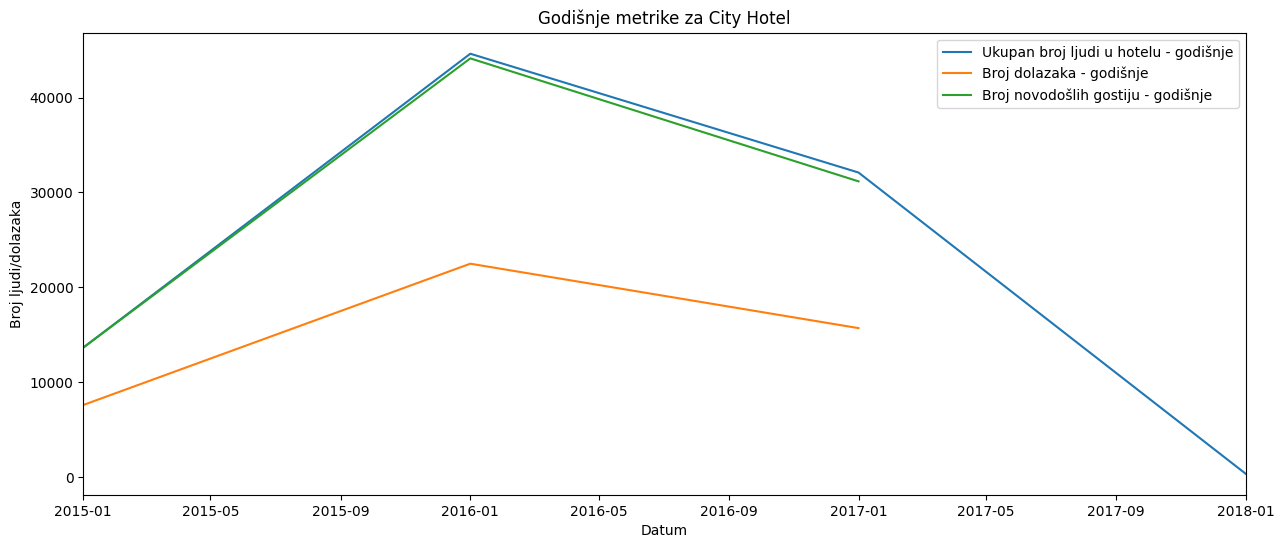

In [83]:
plt.figure(figsize=(15, 6))

plt.plot(NumberOfGuestsYearlyCity.index, NumberOfGuestsYearlyCity['ukupno_gostiju'], label='Ukupan broj ljudi u hotelu - godišnje')
plt.plot(NumberOfArrivalsYearlyCity.index, NumberOfArrivalsYearlyCity['broj_dolazaka'], label='Broj dolazaka - godišnje')
plt.plot(NumberOfNewGuestsYearlyCity.index, NumberOfNewGuestsYearlyCity['ukupno_gostiju'], label='Broj novodošlih gostiju - godišnje')

plt.title('Godišnje metrike za City Hotel')
plt.xlabel('Datum')
plt.xlim(left=NumberOfGuestsYearlyCity.index.min(),right=NumberOfGuestsYearlyCity.index.max())
plt.ylabel('Broj ljudi/dolazaka')
plt.legend()
plt.show()


#### Resort Hotel

##### Dnevna razina

In [84]:
NumberOfGuestsDailyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "daily", "daily_guests.parquet"))
NumberOfArrivalsDailyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "daily", "daily_arrivals.parquet"))
NumberOfNewGuestsDailyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "daily", "daily_new_guests.parquet"))

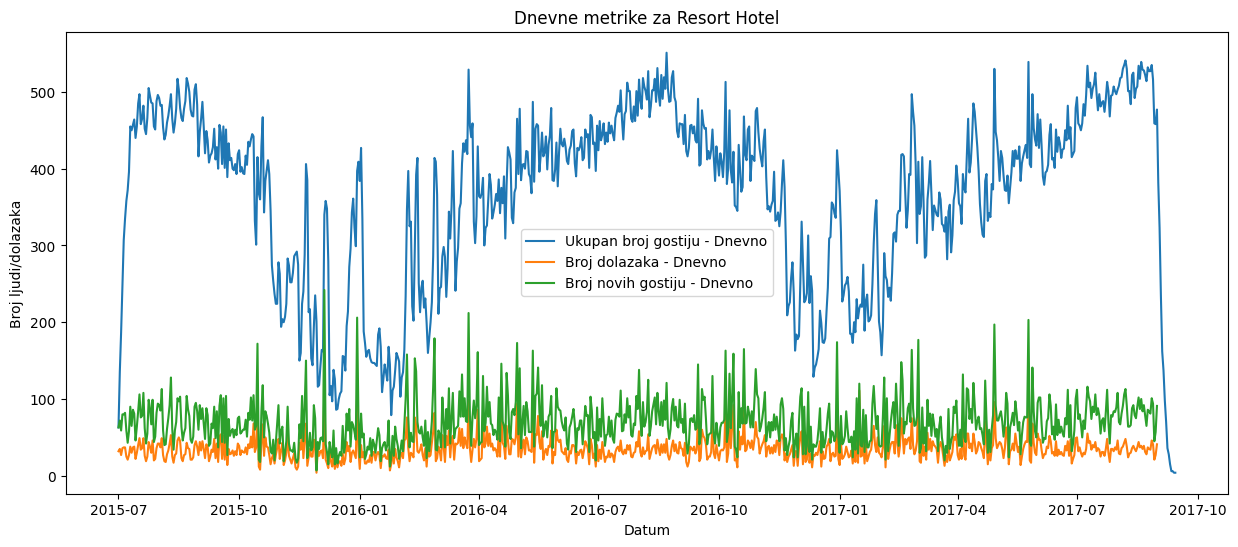

In [85]:
plt.figure(figsize=(15, 6))

plt.plot(NumberOfGuestsDailyResort.index, NumberOfGuestsDailyResort['ukupno_gostiju'], label='Ukupan broj gostiju - Dnevno')
plt.plot(NumberOfArrivalsDailyResort.index, NumberOfArrivalsDailyResort['broj_dolazaka'], label='Broj dolazaka - Dnevno')
plt.plot(NumberOfNewGuestsDailyResort.index, NumberOfNewGuestsDailyResort['ukupno_gostiju'], label='Broj novih gostiju - Dnevno')

plt.title('Dnevne metrike za Resort Hotel')
plt.xlabel('Datum')
plt.ylabel('Broj ljudi/dolazaka')
plt.legend()
plt.show()


##### Tjedna razina

In [86]:
NumberOfGuestsWeeklyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "weekly", "weekly_guests.parquet"))
NumberOfArrivalsWeeklyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "weekly", "weekly_arrivals.parquet"))
NumberOfNewGuestsWeeklyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "weekly", "weekly_new_guests.parquet"))


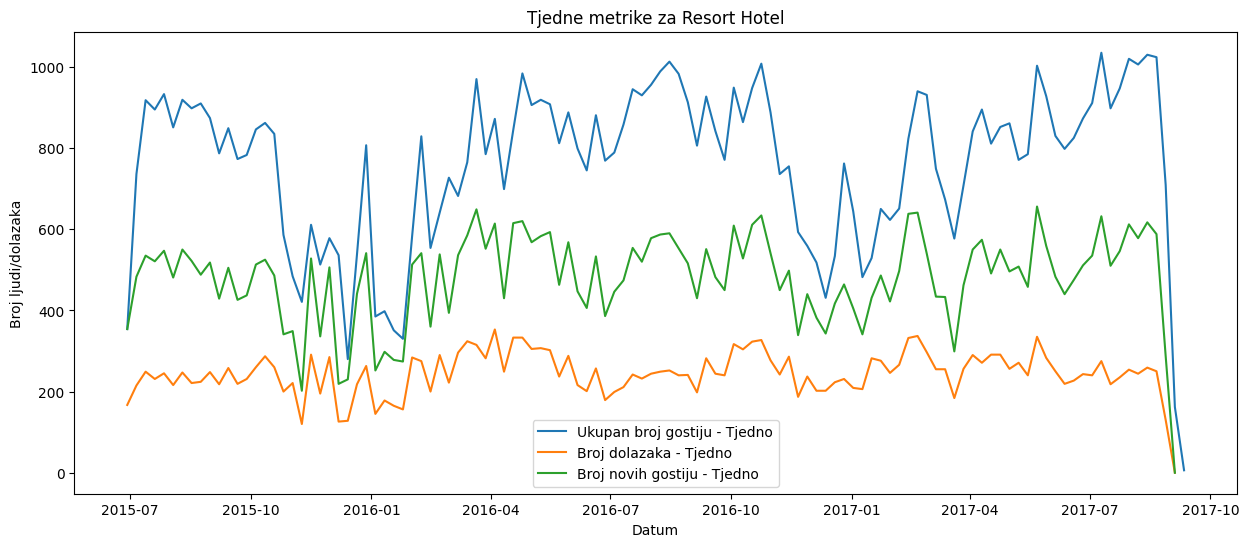

In [87]:
plt.figure(figsize=(15, 6))

plt.plot(NumberOfGuestsWeeklyResort.index, NumberOfGuestsWeeklyResort['ukupno_gostiju'], label='Ukupan broj gostiju - Tjedno')
plt.plot(NumberOfArrivalsWeeklyResort.index, NumberOfArrivalsWeeklyResort['broj_dolazaka'], label='Broj dolazaka - Tjedno')
plt.plot(NumberOfNewGuestsWeeklyResort.index, NumberOfNewGuestsWeeklyResort['ukupno_gostiju'], label='Broj novih gostiju - Tjedno')

plt.title('Tjedne metrike za Resort Hotel')
plt.xlabel('Datum')
plt.ylabel('Broj ljudi/dolazaka')
plt.legend()
plt.show()


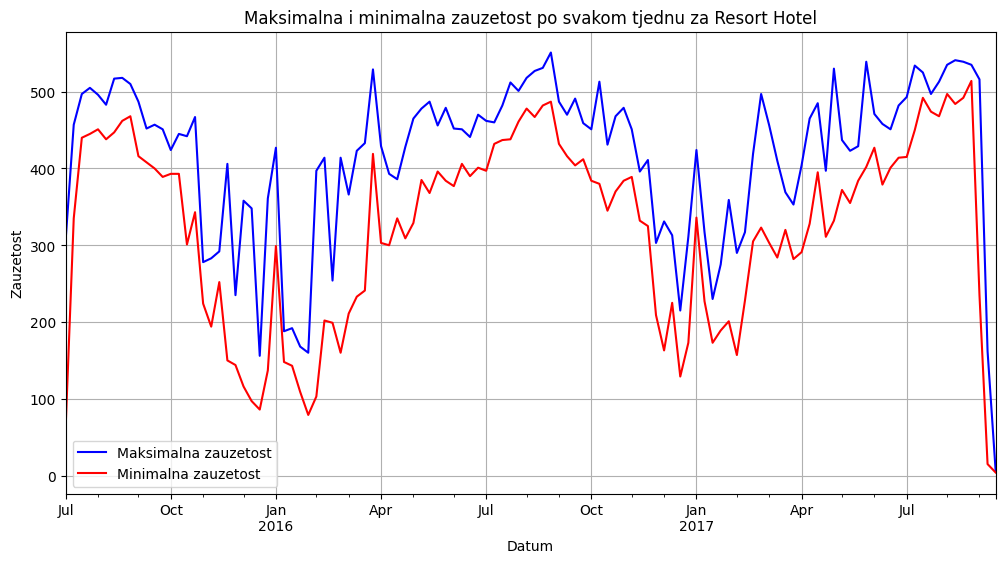

In [88]:
weekly_max = NumberOfGuestsDailyResort['ukupno_gostiju'].resample('W').max()
weekly_min = NumberOfGuestsDailyResort['ukupno_gostiju'].resample('W').min()
weekly_occupancy = pd.DataFrame({'Maksimalna zauzetost': weekly_max, 'Minimalna zauzetost': weekly_min})

plt.figure(figsize=(12, 6))
weekly_occupancy['Maksimalna zauzetost'].plot(color='blue', label='Maksimalna zauzetost')
weekly_occupancy['Minimalna zauzetost'].plot(color='red', label='Minimalna zauzetost')
plt.title('Maksimalna i minimalna zauzetost po svakom tjednu za Resort Hotel')
plt.xlabel('Datum')
plt.ylabel('Zauzetost')
plt.legend()
plt.grid(True)
plt.show()

##### Mjesečna razina

In [89]:
NumberOfGuestsMonthlyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "monthly", "monthly_guests.parquet"))
NumberOfArrivalsMonthlyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "monthly", "monthly_arrivals.parquet"))
NumberOfNewGuestsMonthlyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "monthly", "monthly_new_guests.parquet"))


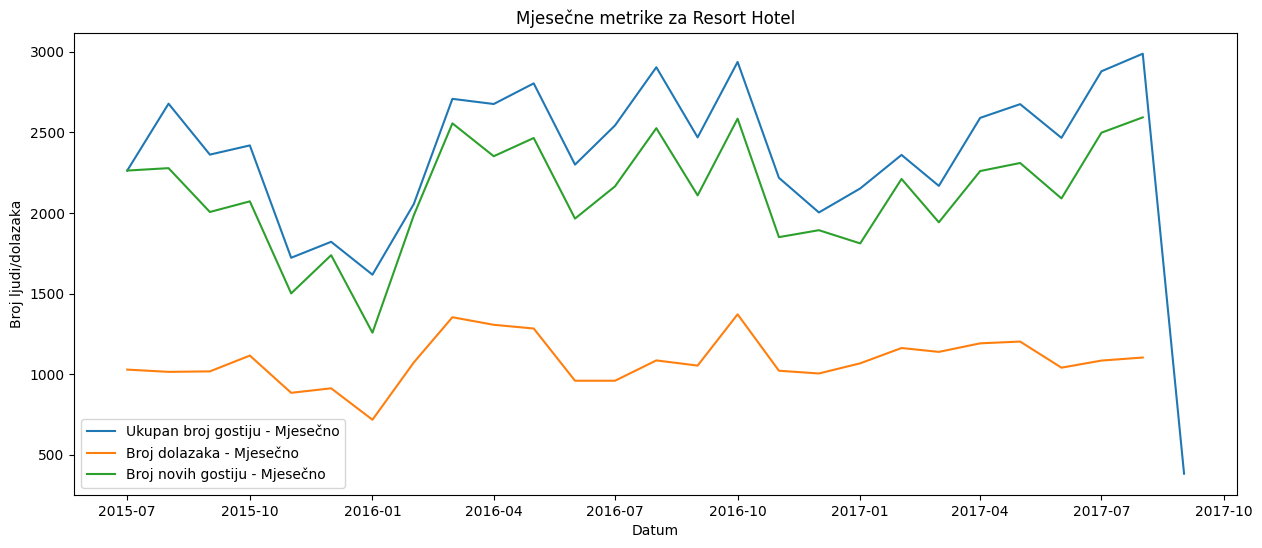

In [90]:
plt.figure(figsize=(15, 6))

plt.plot(NumberOfGuestsMonthlyResort.index, NumberOfGuestsMonthlyResort['ukupno_gostiju'], label='Ukupan broj gostiju - Mjesečno')
plt.plot(NumberOfArrivalsMonthlyResort.index, NumberOfArrivalsMonthlyResort['broj_dolazaka'], label='Broj dolazaka - Mjesečno')
plt.plot(NumberOfNewGuestsMonthlyResort.index, NumberOfNewGuestsMonthlyResort['ukupno_gostiju'], label='Broj novih gostiju - Mjesečno')

plt.title('Mjesečne metrike za Resort Hotel')
plt.xlabel('Datum')
plt.ylabel('Broj ljudi/dolazaka')
plt.legend()
plt.show()


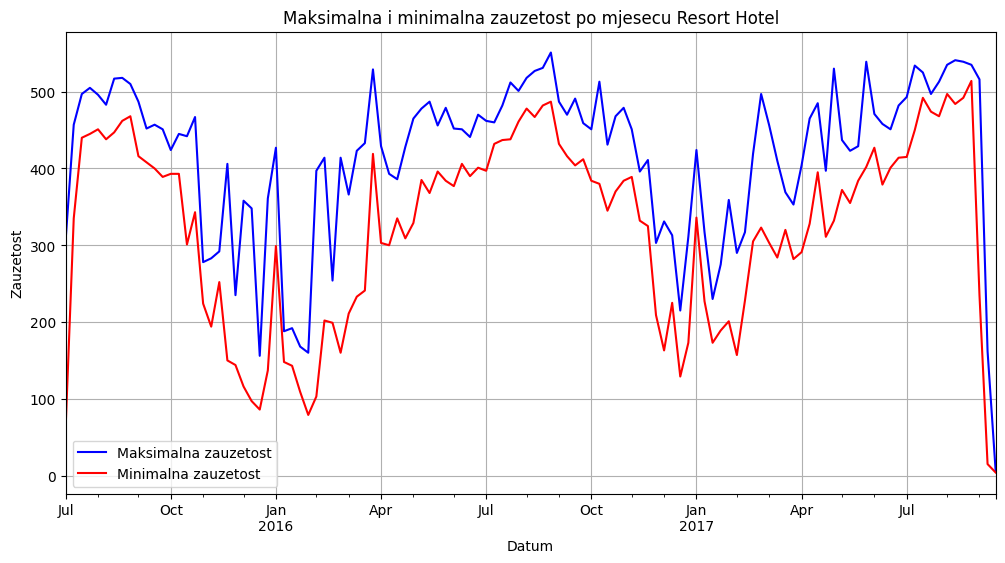

In [91]:
monthly_max= NumberOfGuestsDailyResort['ukupno_gostiju'].resample('MS').max()
monthly_min = NumberOfGuestsDailyResort['ukupno_gostiju'].resample('MS').min()
monthly_occupancy = pd.DataFrame({'Maksimalna zauzetost': monthly_max, 'Minimalna zauzetost': monthly_min})

plt.figure(figsize=(12, 6))
weekly_occupancy['Maksimalna zauzetost'].plot(color='blue', label='Maksimalna zauzetost')
weekly_occupancy['Minimalna zauzetost'].plot(color='red', label='Minimalna zauzetost')
plt.title('Maksimalna i minimalna zauzetost po mjesecu Resort Hotel')
plt.xlabel('Datum')
plt.ylabel('Zauzetost')
plt.legend()
plt.grid(True)
plt.show()

##### Godišnja razina

In [92]:
NumberOfGuestsYearlyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "yearly", "yearly_guests.parquet"))
NumberOfArrivalsYearlyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "yearly", "yearly_arrivals.parquet"))
NumberOfNewGuestsYearlyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "yearly", "yearly_new_guests.parquet"))

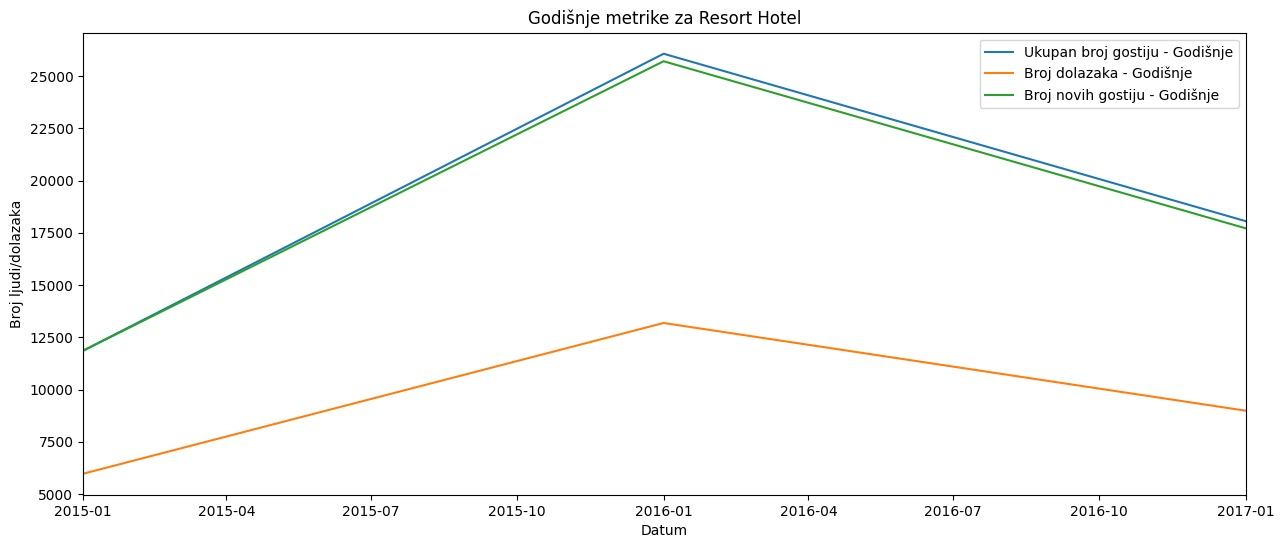

In [93]:
plt.figure(figsize=(15, 6))

plt.plot(NumberOfGuestsYearlyResort.index, NumberOfGuestsYearlyResort['ukupno_gostiju'], label='Ukupan broj gostiju - Godišnje')
plt.plot(NumberOfArrivalsYearlyResort.index, NumberOfArrivalsYearlyResort['broj_dolazaka'], label='Broj dolazaka - Godišnje')
plt.plot(NumberOfNewGuestsYearlyResort.index, NumberOfNewGuestsYearlyResort['ukupno_gostiju'], label='Broj novih gostiju - Godišnje')

plt.title('Godišnje metrike za Resort Hotel')
plt.xlabel('Datum')
plt.ylabel('Broj ljudi/dolazaka')
plt.xlim(left=NumberOfGuestsYearlyResort.index.min(), right=NumberOfGuestsYearlyResort.index.max())
plt.legend()
plt.show()


### Broj rezervacija po kanalu prodaje, specifičnoj vrsti sobe

In [94]:
dataResort = pd.read_parquet(DATA_HOTEL0_PATH)
dataCity =  pd.read_parquet(DATA_HOTEL1_PATH)

#### Hotel 0

##### Broj rezervacija po kanalu prodaje

In [95]:
reservations_per_channel_resort = dataResort.groupby('kanal_prodaje_id').size()
reservations_per_channel_resort

kanal_prodaje_id
0     5446
1     2588
2    37609
4      153
dtype: int64

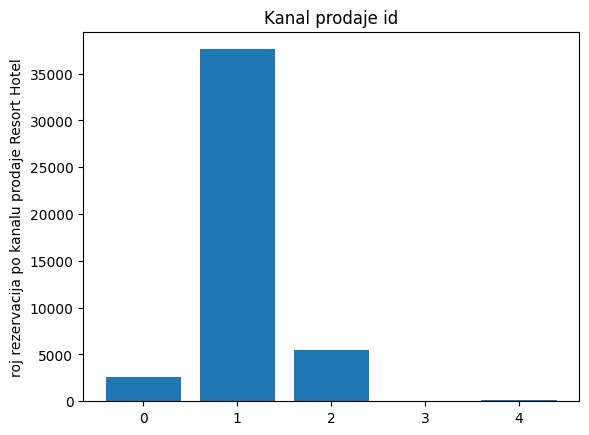

In [96]:
fig, ax = plt.subplots()

ax.bar(dataResort['kanal_prodaje_id'].unique(),reservations_per_channel_resort,label='Broj rezervacija')
ax.set_ylabel('roj rezervacija po kanalu prodaje Resort Hotel')
ax.set_title('Kanal prodaje id')
plt.show()


#### Hotel 1

##### Broj rezervacija po kanalu prodaje

In [97]:
reservations_per_channel_city = dataCity.groupby('kanal_prodaje_id').size()
reservations_per_channel_city

kanal_prodaje_id
0     6302
1     2373
2    19464
3        1
dtype: int64

In [98]:
dataCity['kanal_prodaje_id'].unique()

array([0, 1, 2, 3], dtype=int32)

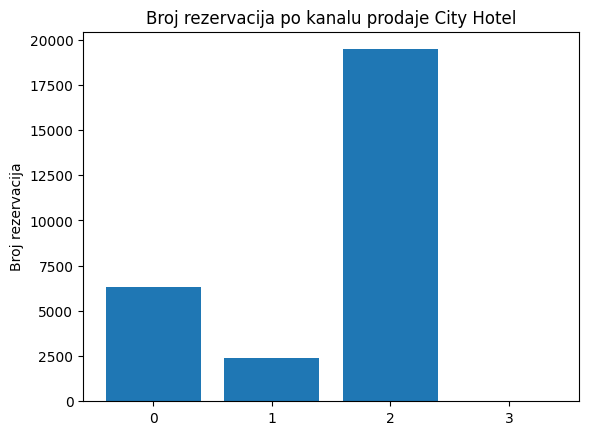

In [99]:
fig, ax = plt.subplots()

ax.bar(dataCity['kanal_prodaje_id'].unique(),reservations_per_channel_city,label='Broj rezervacija')
ax.set_ylabel('Broj rezervacija')
ax.set_title('Broj rezervacija po kanalu prodaje City Hotel')
ax.set_xticks(reservations_per_channel_city.index)  
ax.set_xticklabels(reservations_per_channel_city.index)

plt.show()

### Zanimljiva anomalija u broju novodošlih gostiju u City Hotelu

In [100]:
indexes = NumberOfNewGuestsDailyCity[NumberOfNewGuestsDailyCity['ukupno_gostiju'] == 0].index
periods = []
start_date = indexes[0]
for i in range(1, len(indexes)):
    if (indexes[i] - indexes[i-1]).days > 1:
        end_date = indexes[i-1]
        periods.append((start_date, end_date))
        start_date = indexes[i]

periods.append((start_date, indexes[-1]))

for start, end in periods:
    print(f"Periodi gdje je broj gostiju jednak nuli : od {start.date()} do {end.date()}, ukupno {(end - start).days+1} dana")

Periodi gdje je broj gostiju jednak nuli : od 2015-02-01 do 2015-04-30, ukupno 89 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-06-01 do 2015-06-30, ukupno 30 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-05 do 2015-07-06, ukupno 2 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-12 do 2015-07-14, ukupno 3 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-16 do 2015-07-16, ukupno 1 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-19 do 2015-07-19, ukupno 1 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-21 do 2015-07-21, ukupno 1 dana
Periodi gdje je broj gostiju jednak nuli : od 2017-09-01 do 2017-09-30, ukupno 30 dana


In [101]:
indexes_valid = NumberOfNewGuestsDailyCity[NumberOfNewGuestsDailyCity['ukupno_gostiju'] != 0].index
periods_valid = []
start_date = indexes_valid[0]
for i in range(1, len(indexes_valid)):
    if (indexes_valid[i] - indexes_valid[i-1]).days > 1:
        end_date = indexes_valid[i-1]
        periods_valid.append((start_date, end_date))
        start_date = indexes_valid[i]

periods_valid.append((start_date, indexes_valid[-1]))

for start, end in periods_valid:
    print(f"Periodi gdje je broj gostiju različit nuli : od {start.date()} do {end.date()}, ukupno {(end - start).days+1} dana")

Periodi gdje je broj gostiju različit nuli : od 2015-01-01 do 2015-01-31, ukupno 31 dana
Periodi gdje je broj gostiju različit nuli : od 2015-05-01 do 2015-05-31, ukupno 31 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-01 do 2015-07-04, ukupno 4 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-07 do 2015-07-11, ukupno 5 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-15 do 2015-07-15, ukupno 1 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-17 do 2015-07-18, ukupno 2 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-20 do 2015-07-20, ukupno 1 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-22 do 2017-08-31, ukupno 772 dana
Periodi gdje je broj gostiju različit nuli : od 2017-10-01 do 2017-12-31, ukupno 92 dana


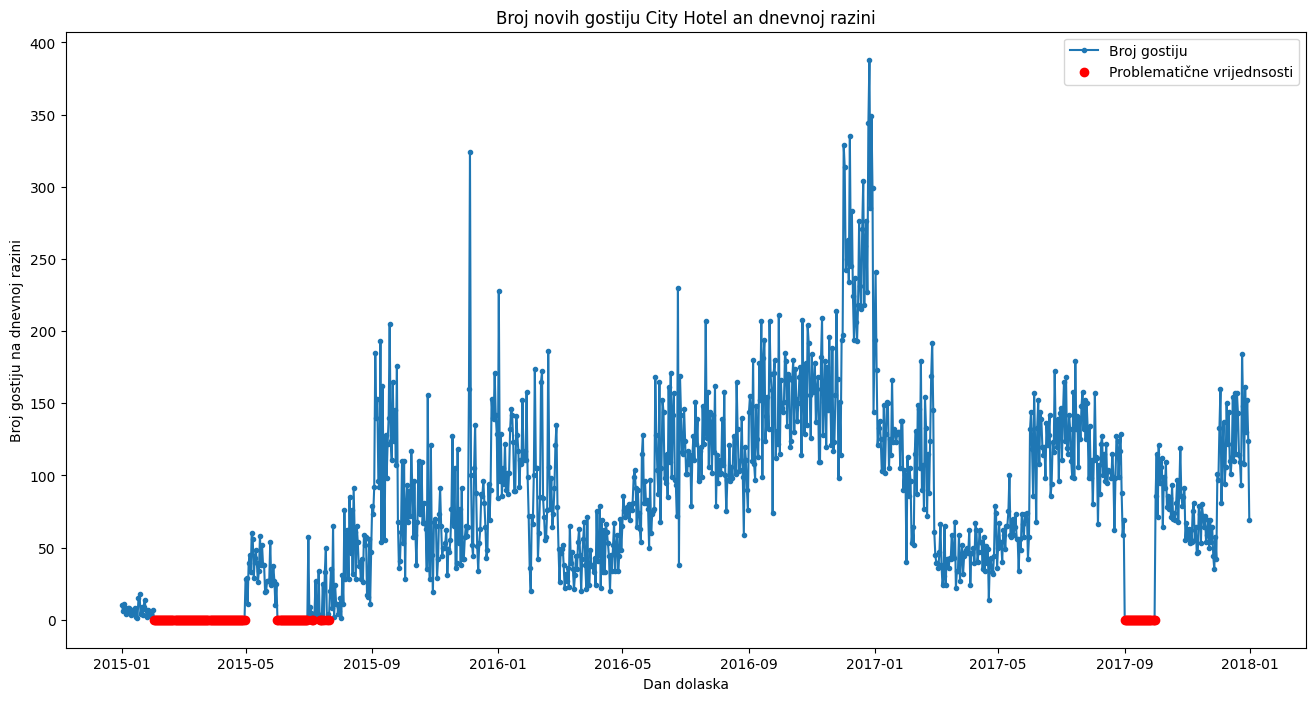

In [102]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfNewGuestsDailyCity['ukupno_gostiju'], marker='.', label='Broj gostiju')
plt.plot(NumberOfNewGuestsDailyCity.loc[indexes, 'ukupno_gostiju'], 'o', color='red', label='Problematične vrijednsosti')

plt.title('Broj novih gostiju City Hotel an dnevnoj razini')
plt.xlabel('Dan dolaska')
plt.ylabel('Broj gostiju na dnevnoj razini')

plt.legend()
plt.show()

ZAKLJUČAK - UKOLIKO SE MODELIRA BROJ NOVIH GOSTIJU/DOLAZAKA
- dio podataka gdje je duljina perioda gdje hotel nema gostiju dulja od tjedan dana ima smisla izbaciti, zajedno s podacima koji prethode, ako govorimo o "malom "uzorku "čistih" podataka koji prethode dugim anomalijama
- kako je taj "mali" uzorak podataka koji smijemo izbaciti arbitraran, moguće je modelirati na više načina, s većom/manjom količinom izbacivanja podataka
- manje periode ima smisla modelirati na način da se agregiraju srednje vrijednosti podatka iz susjedstva (npr. tjedan dana prije i poslije) ili interpolirati srednje vrijednosti iz susjedstva
- prethodno može biti primjenjemo na dulje periode, ukoliko je potrebno
- ARIMA model, kao i MAPE metrika, ne reagiraju dobro na anomalije, odnosno MAPE puca (zbog djeljenja s nulom) ako su ciljani podaci nula, odnosno u ovom slučaju za svaki slučaj kada je broj ukupnih gosti na bilo kojoj vremenskoj bazi jednak nuli


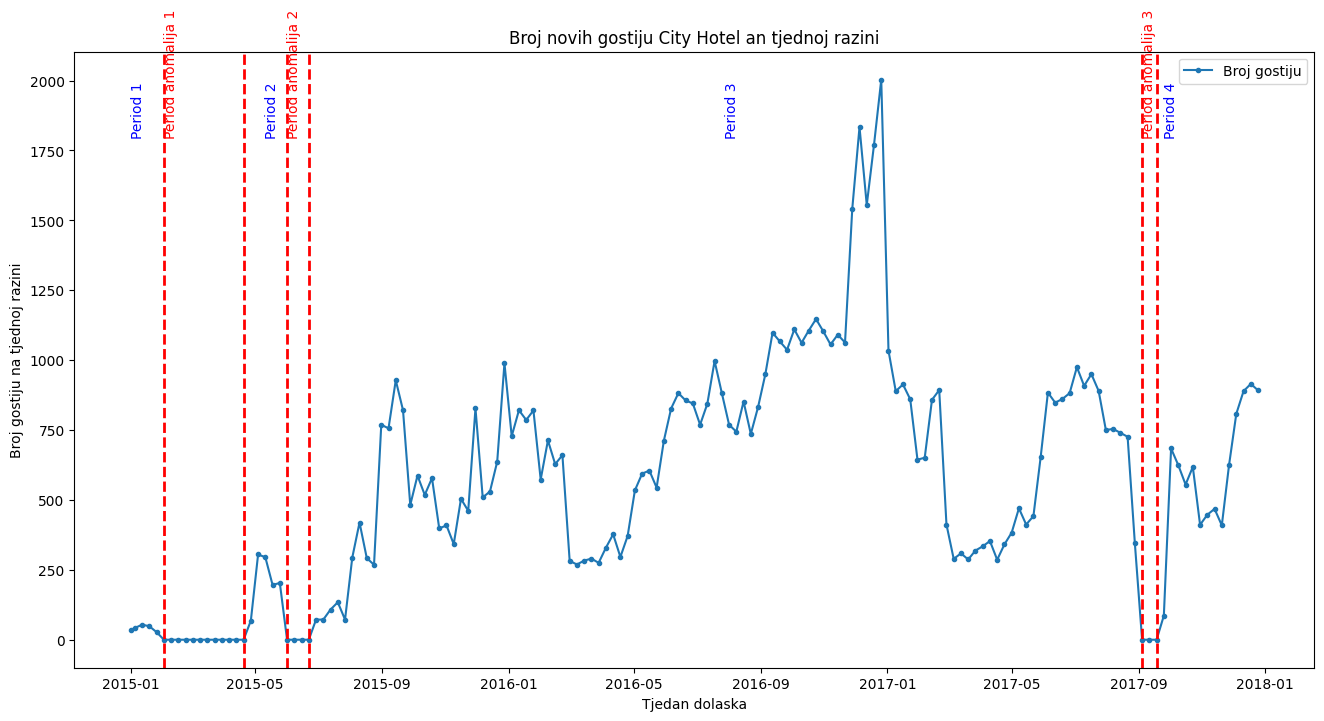

In [103]:
indexes = NumberOfNewGuestsWeeklyCity[NumberOfNewGuestsWeeklyCity['ukupno_gostiju'] == 0].index
periods = []
start_date = indexes[0]

for i in range(1, len(indexes)):
    if (indexes[i] - indexes[i - 1]).days > 7:  
        end_date = indexes[i - 1]
        periods.append((start_date, end_date))
        start_date = indexes[i]

periods.append((start_date, indexes[-1]))

plt.figure(figsize=(16, 8))
plt.plot(NumberOfNewGuestsWeeklyCity['ukupno_gostiju'], marker='.', label='Broj gostiju')

anomalous_period_count = 1
normal_period_count = 1

if periods[0][0] != NumberOfNewGuestsWeeklyCity.index.min():
    first_normal_end = periods[0][0] - pd.Timedelta(weeks=1)
    plt.text(NumberOfGuestsWeeklyCity.index.min(), max(NumberOfNewGuestsWeeklyCity['ukupno_gostiju']) * 0.9, f'Period {normal_period_count}', color='blue', rotation=90)
    normal_period_count += 1

for i, (start, end) in enumerate(periods):
    plt.axvline(x=start, color='red', linestyle='--', lw=2)
    plt.axvline(x=end, color='red', linestyle='--', lw=2)
    plt.text(start, max(NumberOfNewGuestsWeeklyCity['ukupno_gostiju']) * 0.9, f'Period anomalija {anomalous_period_count}', color='red', rotation=90)
    anomalous_period_count += 1

    if i < len(periods) - 1:
        next_start = periods[i + 1][0]
        midpoint = pd.to_datetime((end.value + next_start.value) // 2)
        plt.text(midpoint, max(NumberOfNewGuestsWeeklyCity['ukupno_gostiju']) * 0.9, f'Period {normal_period_count}', color='blue', rotation=90)
        normal_period_count += 1

if periods[-1][1] != NumberOfNewGuestsWeeklyCity.index.max():
    last_normal_start = periods[-1][1] + pd.Timedelta(weeks=1)
    plt.text(last_normal_start, max(NumberOfNewGuestsWeeklyCity['ukupno_gostiju']) * 0.9, f'Period {normal_period_count}', color='blue', rotation=90)
    normal_period_count += 1

plt.title('Broj novih gostiju City Hotel an tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')

plt.legend()
plt.show()


KOMENTAR
- period 1, 2 te 3 označavaju periode podatak iz dataseta gdje postoji dnevni broj gostiju različit od nule, dok periodi anomalija vremenske
periode gdje je ukupan broj gostiju jedan nuli
- prvi period anomalija ćemo izbaciti iz dataseta, kao i period 1 regularnih podataka, kako se radi o kratkom peroidu validnih podataka 
 (imamo 30 dana zapisa i 88 dana bez gostiju)
- drugi period anomalija, kao i treći, razrješiti će se na sljedeći način:
   - za drugi period anomalija gledati ćemo period 2 te određeni dio perioda 3 "zdravih podataka" te izračunati daily mean te dodati tu vrijednosti danima anomalija
   - za treći period koristiti ćemo dio trećeg te četvrtog perioda zdravih podataka i na taj način amputirati podatke u dane anomalija
- ovo se treba raditi na  podatkovnom okviru s dnevnim zapisima, kako na tjednoj razini ne vidimo veću granulaciju, odnosno postoje dani (jedan ili dva u nizu) u kojima 
  nema gostiju, ali koji se "ne vide" na tjednoj bazi,ali utječu na brog gostiju